# TSP problem

In [1]:

# !pip install matplotlib
import pandas as pd
from dataclasses import dataclass
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import time

In [2]:

# Lat = Y Long = X

@dataclass(frozen=True)
class City:
    id: int
    city_name: str
    lat: float
    lon: float

    def __hash__(self):
        return hash(self.id)
    
    # used just to be able to call the lon as x and lat as y
    @property
    def x(self):
        return self.lon

    @property
    def y(self):
        return self.lat

PATH_FILE = ''
DISTANCE_MATRIX = None
CITIES = None
N_CITIES = 0

POP_SIZE = 0
N_GENERATION = 0
ELITE_COUNT = 0
    

In [3]:
# UTILS

def distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the earth given their latitude and longitude in decimal degrees.
    then convert the distance to kilometers using the Haversine formula.
    """

	# approximate radius of earth in km
    R = 6371.0
    
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    # Haversine formula
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # km conversion
    distace = R * c
    return distace


def distance_city(city1, city2):
    """
    Calculate the distance between two cities using the distance matrix precomputed.
    """

    return DISTANCE_MATRIX[city1.id][city2.id]


def get_path_cost(path):
    """
    Calculate the total cost of the path by summing the distances between the cities.
    """

    cost = 0
    for i in range(len(path) - 1):
        cost += distance_city(path[i], path[i + 1])
    # add the distance from the last city to the first city is not necessary since the first city is repeated at the end in the path
    # cost += distance_city(path[-1], path[0])  # Back to the first city
    return cost


def nearest_city(c, remainingCities):
    """
    Find the nearest city to the given city c from the list of remaining cities.
    """
    
    # Initialize the nearest city to the first city in the list
    min_distance = distance_city(c, remainingCities[0])
    nearest_city = remainingCities[0]

    # Find the nearest city scanning the remaining cities
    for city in remainingCities:
        d = distance_city(c, city)
        if d < min_distance:
            min_distance = d
            nearest_city = city

    return nearest_city


def plot_path(path, title):
    """
    Plot the path on a map.
    title: The title of the plot.
    """

    # Get the coordinates of the path
    latitudes = [city.lat for city in path] + [path[0].lat]  # Back to the first city
    longitudes = [city.lon for city in path] + [path[0].lon]

    # Create the plot
    plt.figure(figsize=(25, 15))
    plt.plot(longitudes, latitudes, marker='o', color='b', linestyle='-', markersize=5, linewidth=1, label="Path")
    
    # Highlight the starting point in red
    plt.plot(path[0].lon, path[0].lat, marker='o', color='r', markersize=10, label="Starting Point")
    
    # Highlight the second city in green
    plt.plot(path[1].lon, path[1].lat, marker='o', color='g', markersize=10, label="Second City")

    # Add city names
    if len(path) < 50: # Avoid too many labels
        for city in path:
            plt.text(city.lon, city.lat, city.city_name, fontsize=9, ha='right')
    
    # Add the title and labels to the plot
    plt.title(title)
    plt.xlabel("lon")
    plt.ylabel("lat")
    plt.legend()

    # Show the plot
    plt.show()

def get_path_string(path):
    """
    Get a string representation of the path.
    The string will be in the format: "City1 -> City2 -> ... -> CityN" where city1, city2, ..., cityN are the names of the cities in the path.
    """

    s = ""
    for i, city in enumerate(path):
        s += f"{city.city_name} -> "
        if (i + 1) % 10 == 0:  # Add a newline after every 10 cities
            s += "\n"
    return s

def valid_path(path):
    """
    Check if the path is valid.
    A valid path should:
    - Have the correct number of cities (N_CITIES + 1)
    - Start and end at the same city
    - Include all cities
    """

    # check if the path has the correct number of cities
    if len(path) < N_CITIES + 1:
        return False
    # check if the path starts and ends at the same city
    if path[0] != path[-1]:
        return False
    # check if all cities are in the path
    for i in range(N_CITIES):
        if CITIES[i] not in path:
            return False
    return True


def fitness(path):
    """
    Calculate fitness of a path; higher is better. 
    Invalid paths get zero fitness.
    """

    if not valid_path(path):
        return (0)
    fitness = 1 / get_path_cost(path)  # Fitness is inversely proportional to path cost
    return fitness


## Quick alghoritm

In [ ]:


# Define a function that computes the path and cost for a starting city
def calculate_path_from_city_closest(i):
    """
    Calculate the path and cost for a starting city by selecting the nearest city at each step.
    return: The path and the respective cost.
    """

    path = []
    current_city = CITIES[i]
    path.append(current_city)

    # Set remaining cities as all except the starting city
    remainingCities = [city for city in CITIES if city != current_city]

    # Find the nearest city at each step
    while len(remainingCities) > 0:
        nearest = nearest_city(current_city, remainingCities)
        path.append(nearest)
        remainingCities.remove(nearest)
        current_city = nearest

    path.append(CITIES[i]) # Return to the starting city
    path_cost = get_path_cost(path)
    return path, path_cost


def calculate_circular_path_clockwise(i, type):
    """
    Calculate the path and cost for a starting city by selecting the nearest city in a circular manner.
    type: The type of the circular path, either "clockwise" or "counter-clockwise".
    return: The path and the respective cost.
    """

    current_city = CITIES[i]
    remaining_cities = [city for city in CITIES if city != current_city]

    path = [current_city]

    directions = []

    if type == "clockwise":
        # Define direction checks in the specific order: up-left, up-right, down-right, down-left (clockwise)
        directions = [
            (-1, 1),   # up-left
            (1, 1),    # up-right
            (1, -1),   # down-right
            (-1, -1)   # down-left
        ]
    else:
        # Define direction checks in the specific order: up-right, down-right, down-left, up-left (counter-clockwise)
        directions = [
            (1, -1),   # down-right
            (-1, -1),  # down-left
            (-1, 1),    # up-left
            (1, 1)    # up-right
        ]
    

    # Find the nearest city in each direction
    while remaining_cities:

        city_found = False  # Flag to check if a city was found in any direction

        # Check each direction in the order defined
        for dx, dy in directions:
            city_temp = None

            # Filter cities in the current direction
            candidates = [
                c for c in remaining_cities
                if (c.x - current_city.x) * dx > 0 and (c.y - current_city.y) * dy > 0
            ]

            if len(candidates) == 0:
                continue

            #print ("Start from: ", current_city.city_name, "Candidates: ", len(candidates), ": ", [c.city_name for c in candidates])

            # Find the optimal city in the current direction
            city_temp = nearest_city(current_city, candidates)

            # If a city in the current direction is found, add it to path
            if city_temp:
                path.append(city_temp)
                remaining_cities.remove(city_temp)
                current_city = city_temp
                city_found = True  # Mark that we found a city and updated the path
                break  # Restart with up-left from the new city

        # If no city is found in any direction, the loop will end naturally
        if not city_found:
            break
    
    path.append(CITIES[i])  # Return to the starting city
    path_cost = get_path_cost(path)
    return path, path_cost


# Define a function that computes the path and cost for a starting city
def calculate_path_from_city(i):
    """
    Calculate the path and cost for a starting city
    the path is calculated using the closest city to the current city in three different ways:
    - selecting the nearest city at each step
    - selecting the nearest city in a circular manner (clockwise)
    - selecting the nearest city in a circular manner (counter-clockwise)
    return: The best path and the respective cost.
    """
    
    path_closest, cost_closest = calculate_path_from_city_closest(i)
    path_circular_clockwise, cost_circular_clockwise = calculate_circular_path_clockwise(i, "clockwise")
    path_circular_counter_clockwise, cost_circular_counter_clockwise = calculate_circular_path_clockwise(i, "counter-clockwise")

    if cost_closest < cost_circular_clockwise and cost_closest < cost_circular_counter_clockwise:
        return path_closest, cost_closest
    
    if cost_circular_clockwise < cost_closest and cost_circular_clockwise < cost_circular_counter_clockwise:
        return path_circular_clockwise, cost_circular_clockwise

    return path_circular_counter_clockwise, cost_circular_counter_clockwise



def quick_algorithm(country):
    """
    Run the quick algorithm to find the best path for the given country.
    country: The name of the country.
    return: The top 3 paths found by the algorithm.
    """

    print("-----------------------------")
    print("------ Quick Algorithm ------")
    print("-----------------------------")

    print ("Country: ", country)

    PATHS = []
    COSTS = []

    # Use ThreadPoolExecutor for managing threads
    with ProcessPoolExecutor() as executor:
        # Submit tasks for each city and store futures with city index
        futures = {executor.submit(calculate_path_from_city, city): city for city in range(N_CITIES)}
        
        # Retrieve and store results as they complete, with progress tracking
        for future in tqdm(as_completed(futures), total=N_CITIES):
            try:
                path, path_cost = future.result()
                PATHS.append(path)
                COSTS.append(path_cost)
            except Exception as e:
                city_index = futures[future]
                print(f"Error calculating path for city {city_index}: {e}")


    # Sort the paths by cost
    for i in range(len(COSTS)):
        for j in range(i+1, len(COSTS)):
            if COSTS[i] > COSTS[j]:
                # swap both the costs and the paths
                COSTS[i], COSTS[j] = COSTS[j], COSTS[i]
                PATHS[i], PATHS[j] = PATHS[j], PATHS[i]

    # Extract the best path and cost
    best_cost = COSTS[0]
    best_path = PATHS[0]

    # Extract the worst cost
    worst_cost = COSTS[-1]

    # Calculate the average cost
    average_cost = sum(COSTS) / len(COSTS)

    # Count occurrences of each cost
    cost_dict = {}
    for cost in COSTS:
        cost_dict[cost] = cost_dict.get(cost, 0) + 1

    # Print the summary statistics
    print("Number of cities:", N_CITIES)
    print("Number of different costs:", len(cost_dict))
    print("Worst path cost:", worst_cost)
    print("Average cost:", average_cost)
    print("Best path cost:", best_cost)

    # Extract the top 3 paths without their costs
    top_3_paths = PATHS[:3]

    # Plot the best path
    plot_path(best_path, "Best path quick algorithm for country: " + country) 

    # Return the top 3 paths for further analysis
    return top_3_paths


## Slow Algorithm

In [ ]:


def semi_rand_path(i):
    """
    Calculate a path from a city to all other cities.
    While calculating the path, the nearest city is selected with a 50% chance.
    i: The index of the starting city.
    return: The path.
    """

    path = []
    current_city = CITIES[i]
    path.append(current_city)

    # Set remaining cities as all except the starting city
    remainingCities = [city for city in CITIES if city != current_city]

    while len(remainingCities) > 0:
        r = random.random()
        nearest = None

        # 50% chance to select the nearest city or a random one
        if r < 0.5:
            nearest = nearest_city(current_city, remainingCities)
        else:
            nearest = random.choice(remainingCities)

        path.append(nearest)
        remainingCities.remove(nearest)
        current_city = nearest


    path.append(CITIES[i]) # Return to the starting city
    return path


def initialize_population(p):
    """"
    Initialize the population with a mix of fast and random paths.
    The 20% of the population will be initialized with semi-random paths, the remaining 80% will be initialized with random paths.
    p: The best paths from the quick algorithm (if any).
    return: The initialized population
    """

    population = []
    pre_initialized = 0

    # if any paths are provided from the quick algorithm, add them to the population
    if p is not None:
        pre_initialized = len(p)
        population.extend(p)
        print (f"Best cost from quick algorithm: {get_path_cost(p[0])}")

    PERCENTAGE_FAST_PATHS = 0.20
    smart_path = int(N_CITIES*PERCENTAGE_FAST_PATHS)
    random_idxs = []


    for i in range(POP_SIZE - pre_initialized):

        # Use semi-random paths for the first 20% of the population
        if i < smart_path:

            # avoid repeating the same city as starting city
            rand_idx = random.randint(0, N_CITIES - 1)
            while rand_idx in random_idxs:
                rand_idx = random.randint(0, N_CITIES - 1)
            individual = semi_rand_path(rand_idx)
            random_idxs.append(rand_idx)

        # Use random paths for the remaining 80% of the population
        else:
            individual = random.sample(CITIES, N_CITIES)  # Generate a random path
            individual.append(individual[0]) # Add the starting city to the end to complete the path

        population.append(individual)
    return population


def selection(population, fitness_scores):
    """
    Select the best paths based on fitness.
    population: The current population.
    fitness_scores: The fitness scores of the population.
    return: The selected population.
    """

    selected = random.choices(
        population, weights=fitness_scores, k=len(population)
    )  # Probability-proportional selection, weighted by fitness
    return selected


def order_crossover(parent1, parent2):
    """
    Combine two parents to create a child.
    The child is generated using the order crossover method.
    parent1: The first parent.
    parent2: The second parent.
    """

    size = len(parent1) - 1
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size

    # Copy the crossover segment from parent1 to the child
    child[start:end] = parent1[start:end]

    ptr = 0
    # Fill remaining positions in child with values from parent2
    for gene in parent2:
        if gene not in child:
            while child[ptr] is not None:
                ptr += 1
            child[ptr] = gene

    child.append(child[0])  # Complete the path
    return child


def partially_mapped_crossover(parent1, parent2):
    """
    Combine two parents to create two children.
    The children are generated using the partially mapped crossover method.
    parent1: The first parent.
    parent2: The second parent.
    return: The two children.
    """

    # Define the length of the tour without the closing city
    size = len(parent1) - 1

    # Select crossover points
    start, end = sorted(random.sample(range(size), 2))

    # Initialize children with None values
    child1 = [None] * size
    child2 = [None] * size

    # Copy the crossover segment from each parent to the respective child
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]

    # Fill remaining positions in child1 using values from parent2
    for i in range(size):
        if child1[i] is None:
            gene = parent2[i]
            while gene in child1:
                # Get the index of the gene in parent1 and map it back to parent2
                gene = parent1[parent2.index(gene)]
            child1[i] = gene

    # Fill remaining positions in child2 using values from parent1
    for i in range(size):
        if child2[i] is None:
            gene = parent1[i]
            while gene in child2:
                # Get the index of the gene in parent2 and map it back to parent1
                gene = parent2[parent1.index(gene)]
            child2[i] = gene

    # Add the starting city to the end to complete the cycle
    child1.append(child1[0])
    child2.append(child2[0])

    return child1, child2


def cycle_crossover(parent1, parent2):
    """
    Combine two parents to create two children.
    The children are generated using the cycle crossover method.
    parent1: The first parent.
    parent2: The second parent.
    return: The two children.
    """

    size = len(parent1) - 1
    child1 = [None] * size
    child2 = [None] * size

    # Create a mapping of positions
    pos1 = {}
    pos2 = {}
    for i in range(size):
        pos1[parent1[i]] = i
        pos2[parent2[i]] = i

    # Cycle start index
    cycle_start = 0
    while None in child1:  # While there are still None values in child1
        current1 = parent1[cycle_start]
        current2 = parent2[cycle_start]

        while child1[pos1[current1]] is None:
            # Fill child1 with genes from parent1 and child2 with genes from parent2
            child1[pos1[current1]] = current1
            child2[pos1[current2]] = current2
            
            # Move to the next genes in the cycles
            current1 = parent1[pos2[current2]]
            current2 = parent2[pos1[current1]]

        # Move to the next cycle start
        cycle_start += 1
        while cycle_start < size and child1[cycle_start] is not None:
            cycle_start += 1

    # Fill in remaining cities in child1 and child2 from the other parent
    for i in range(size):
        if child1[i] is None:
            child1[i] = parent2[i]
        if child2[i] is None:
            child2[i] = parent1[i]

    child1.append(child1[0])  # Complete the path for child1
    child2.append(child2[0])  # Complete the path for child2

    return child1, child2  # Return both children


def scramble_mutation(individual):
    """
    Mutation method that scrambles a segment of the path.
    individual: The path to mutate.
    return: The mutated path.
    """
    
    # Select two indices for the segment
    start, end = sorted(random.sample(range(1, len(individual) - 1), 2))  # Exclude first and last city
    segment = individual[start:end]
    
    # Scramble the segment
    random.shuffle(segment)
    
    # Create a new individual with the scrambled segment
    new_individual = individual[:start] + segment + individual[end:]
    
    return new_individual


def inversion_mutation(individual):
    """
    Mutation method that inverts a segment of the path.
    individual: The path to mutate.
    return: The mutated path.
    """

    start, end = sorted(random.sample(range(1, len(individual) - 1), 2))
    individual[start:end] = individual[start:end][::-1]  # Reverse segment
    return individual


def swap_mutation(individual):
    """
    Mutation method that swaps two cities in the path.
    individual: The path to mutate.
    return: The mutated path.
    """

    # Select two indices to swap cities
    i, j = random.sample(range(1, len(individual) - 1), 2)
    individual[i], individual[j] = individual[j], individual[i]  # Swap cities
    return individual


def adaptive_mutation_rate(generation):
    """
    Calculate the mutation rate based on the generation number.
    The mutation rate decreases linearly from 20% to 1% over the generations.
    generation: The current generation number.
    return: The mutation rate.
    """

    MAX_MUTATION_RATE = 0.20
    MIN_MUTATION_RATE = 0.01

    # Linearly decrease the mutation rate over the generations
    rate = MAX_MUTATION_RATE - (MAX_MUTATION_RATE - MIN_MUTATION_RATE) * generation / N_GENERATION

    return rate


def xover_and_mutate(pair, mutation_rate):
    """
    Perform crossover and mutation on a pair of parents.
    The xover is always performed, while the mutation is performed with the given probability.
    The crossover method is selected randomly between order, partially mapped, and cycle.
    The mutation method is selected randomly between scramble, inversion, and swap.
    pair: The pair of parents.
    mutation_rate: The mutation rate.
    return: The pair of children.
    """

    parent1, parent2 = pair

    r = random.random()

    # Select crossover method
    if r < 1/3:
        child1 = order_crossover(parent1, parent2)
        child2 = order_crossover(parent2, parent1)
    elif r < 2/3:
        child1, child2 = partially_mapped_crossover(parent1, parent2)
    else:
        child1, child2 = cycle_crossover(parent1, parent2)


    # Check if mutation should occur
    if random.random() < mutation_rate:

        initial_child1 = child1.copy()
        initial_child2 = child2.copy()

        r = random.random()

        for _ in range(10):
            
            if r < 1/3:
                child1 = scramble_mutation(child1)
                child2 = scramble_mutation(child2)
            elif r < 2/3:
                child1 = inversion_mutation(child1)
                child2 = inversion_mutation(child2)
            else:
                child1 = swap_mutation(child1)
                child2 = swap_mutation(child2)

            # Check if mutated children are valid paths
            if valid_path(child1) and valid_path(child2):
                break
            else:
                # Revert to initial valid children if mutation is not valid
                child1 = initial_child1.copy()
                child2 = initial_child2.copy()
                
    return child1, child2


def evolve_population(selected_population, generation):
    """
    Evolve the population by performing crossover and mutation.
    selected_population: The selected population.
    generation: The current generation number.
    return: The next generation.
    """

    next_generation = selected_population[:ELITE_COUNT]  # Keep elite unchanged
    mutation_rate = adaptive_mutation_rate(generation)

    # Preparing pairs of parents, each pair will generate two children
    parent_pairs = [
        (selected_population[i], selected_population[i + 1] if i + 1 < POP_SIZE else selected_population[0])
        for i in range(0, POP_SIZE - ELITE_COUNT, 2)
    ]

    # Parallel processing for crossover and mutation
    num_cores = multiprocessing.cpu_count()
    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        futures = [executor.submit(xover_and_mutate, pair, mutation_rate) for pair in parent_pairs]
        for f in as_completed(futures):
            next_generation.extend(f.result())

    return next_generation


def fitness_chunk(chunk):
    """
    Calculates fitness for a chunk of the population.
    chunk: The chunk of the population.
    return: The fitness scores for the chunk.
    """

    return [fitness(individual) for individual in chunk]


def calculate_fitness_scores(population, num_cores):
    """
    Calculate fitness scores for the population using parallel processing.
    population: The population.
    num_cores: The number of CPU cores to use.
    return: The fitness scores for the population.
    """

    chunk_size = math.ceil(len(population) / num_cores)  # Optimal chunking
    population_chunks = [population[i:i + chunk_size] for i in range(0, len(population), chunk_size)]

    fitness_scores = []
    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        # Map the fitness calculation function to each chunk of the population
        chunk_fitness = executor.map(fitness_chunk, population_chunks)
        
        # Flattening the list of fitness scores from chunks
        fitness_scores = [score for sublist in chunk_fitness for score in sublist]

    return fitness_scores


def slow_algorithm(country, best_paths_quick):
    print("---------------------------")
    print("----- Slow Algorithm ------")
    print("---------------------------")

    global POP_SIZE, N_GENERATION, ELITE_COUNT

    # Constants
    POPULATION_SIZE_FACTOR = 3 # Population size factor
    GENERATION_SIZE_FACTOR = 5 # Generation size factor
    PERCENTAGE_ELITE = 0.15 # Percentage of elite individuals to preserve
    
    POP_SIZE =  int(max(50, min(500, round(POPULATION_SIZE_FACTOR * math.log(N_CITIES)))))  # Population size

    N_GENERATION = max(100, min(2000, round(GENERATION_SIZE_FACTOR * N_CITIES)))  # Number of generations

    ELITE_COUNT = int(POP_SIZE * PERCENTAGE_ELITE)  # Number of elite individuals to preserve
    

    print_counter = int(N_GENERATION / 10) # print progress every 10% of the generations

    print(f"Country: {country}")
    print(f"Population Size: {POP_SIZE}")
    print(f"Number of cities: {N_CITIES}")
    print(f"Number of Generations: {N_GENERATION}")
    print(f"Elite Count: {ELITE_COUNT}")

    print("Initializing the algorithm...")

    # Initialize population with the best paths from the quick algorithm
    population = initialize_population(best_paths_quick)
    best_path = None
    best_cost = float('inf')

    # Number of CPU cores to use
    num_cores = multiprocessing.cpu_count()
    pre_best = None

    print("Startign the algorithm...")
    for generation in tqdm(range(N_GENERATION)):

        # Calculate fitness scores for the current population
        fitness_scores = calculate_fitness_scores(population, num_cores)

        # Find the best path of the current generation
        best_gen_path = population[fitness_scores.index(max(fitness_scores))]
        best_gen_cost = get_path_cost(best_gen_path)
        
        # Update the best path found so far
        if best_gen_cost < best_cost:
            best_path = best_gen_path
            best_cost = best_gen_cost

        if generation % print_counter == 0:
            if pre_best is None:
                pre_best = best_cost
                print(f"Generation {generation}, Best Cost so far: {best_cost}")
            else:
                print(f"Generation {generation}, Best Cost so far: {best_cost}, Improvement: {pre_best - best_cost}")
                pre_best = best_cost

        # Selection
        selected_population = selection(population, fitness_scores)

        next_generation = evolve_population(selected_population, generation)

        # Elitism: Preserve the best individuals from the current population
        elite_population = sorted(population, key=get_path_cost)[:ELITE_COUNT]
        population = next_generation[:POP_SIZE - ELITE_COUNT] + elite_population


    print(f"Best Cost: {best_cost}")

    # Plot the best path
    plot_path(best_path, "Slow Algorithm Best Path for country: " + country)
    return


SyntaxError: unterminated triple-quoted string literal (detected at line 394) (3979922810.py, line 298)

## Setup functions utils

In [6]:
# SETUP FUNCTIONS

def print_data():
	for i in range(N_CITIES):
		print("city id: ", i, "city name: ", CITIES[i].city_name)

	header = [""] + [city.city_name for city in CITIES]
	print("\t\t\t".join(header))
	for i, city in enumerate(CITIES):
		row = [city.city_name] + [f"{DISTANCE_MATRIX[i][j]:.2f}" for j in range(N_CITIES)]
		print("\t\t\t".join(row))

def fill_distance_matrix():
	global DISTANCE_MATRIX
	DISTANCE_MATRIX = np.zeros((N_CITIES, N_CITIES))
	for i in range(N_CITIES):
		for j in range(N_CITIES):
			DISTANCE_MATRIX[i][j] = distance(CITIES[i].lat, CITIES[i].lon, CITIES[j].lat, CITIES[j].lon)

def read_data():
	global PATH_FILE, CITIES, N_CITIES
	df = pd.read_csv(PATH_FILE, header=None, names=['city_name', 'lat', 'lon'])
	CITIES = [City(i, row['city_name'], row['lat'], row['lon']) for i, row in df.iterrows()]
	N_CITIES = len(CITIES)

## Main

+-------------------------------------------------------+
|                                                       |
|                        VANUATU                        |
|                                                       |
+-------------------------------------------------------+
-----------------------------
------ Quick Algorithm ------
-----------------------------
Country:  VANUATU


  0%|          | 0/8 [00:00<?, ?it/s]

Number of cities: 8
Number of different costs: 6
Worst path cost: 1456.5944994208985
Average cost: 1376.21842667315
Best path cost: 1350.8735333164125


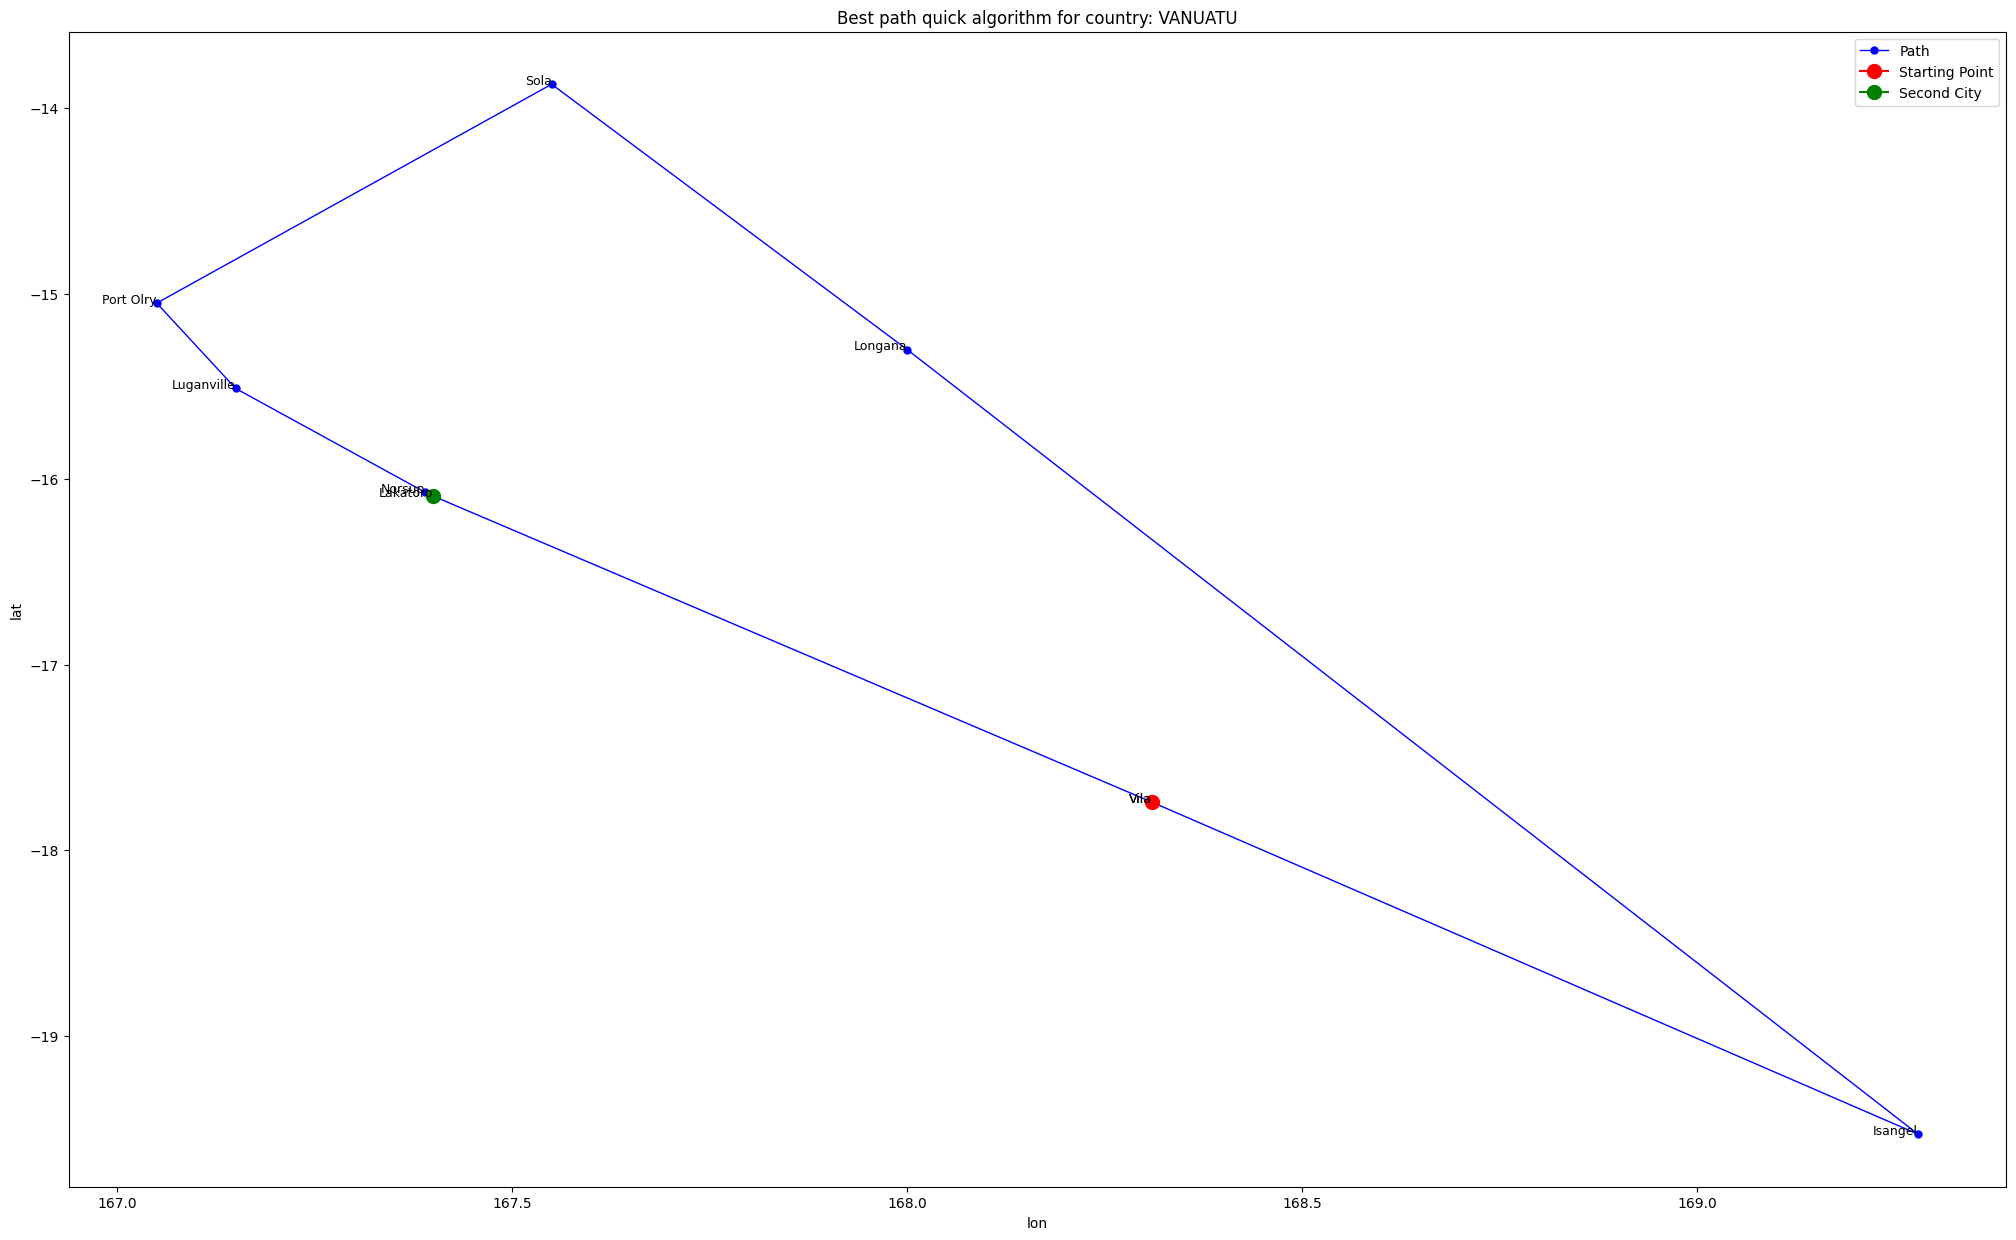

VANUATU Quick Algorithm execution time:  0.49746179580688477


---------------------------
----- Slow Algorithm ------
---------------------------
Country: VANUATU
Population Size: 50
Number of cities: 8
Number of Generations: 100
Elite Count: 7
Initializing the algorithm...
Best cost from quick algorithm: 1350.8735333164125
Startign the algorithm...


  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0, Best Cost so far: 1350.8735333164125
Generation 10, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Generation 20, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Generation 30, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Generation 40, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Generation 50, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Generation 60, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Generation 70, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Generation 80, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Generation 90, Best Cost so far: 1350.8735333164125, Improvement: 0.0
Best Cost: 1350.8735333164125


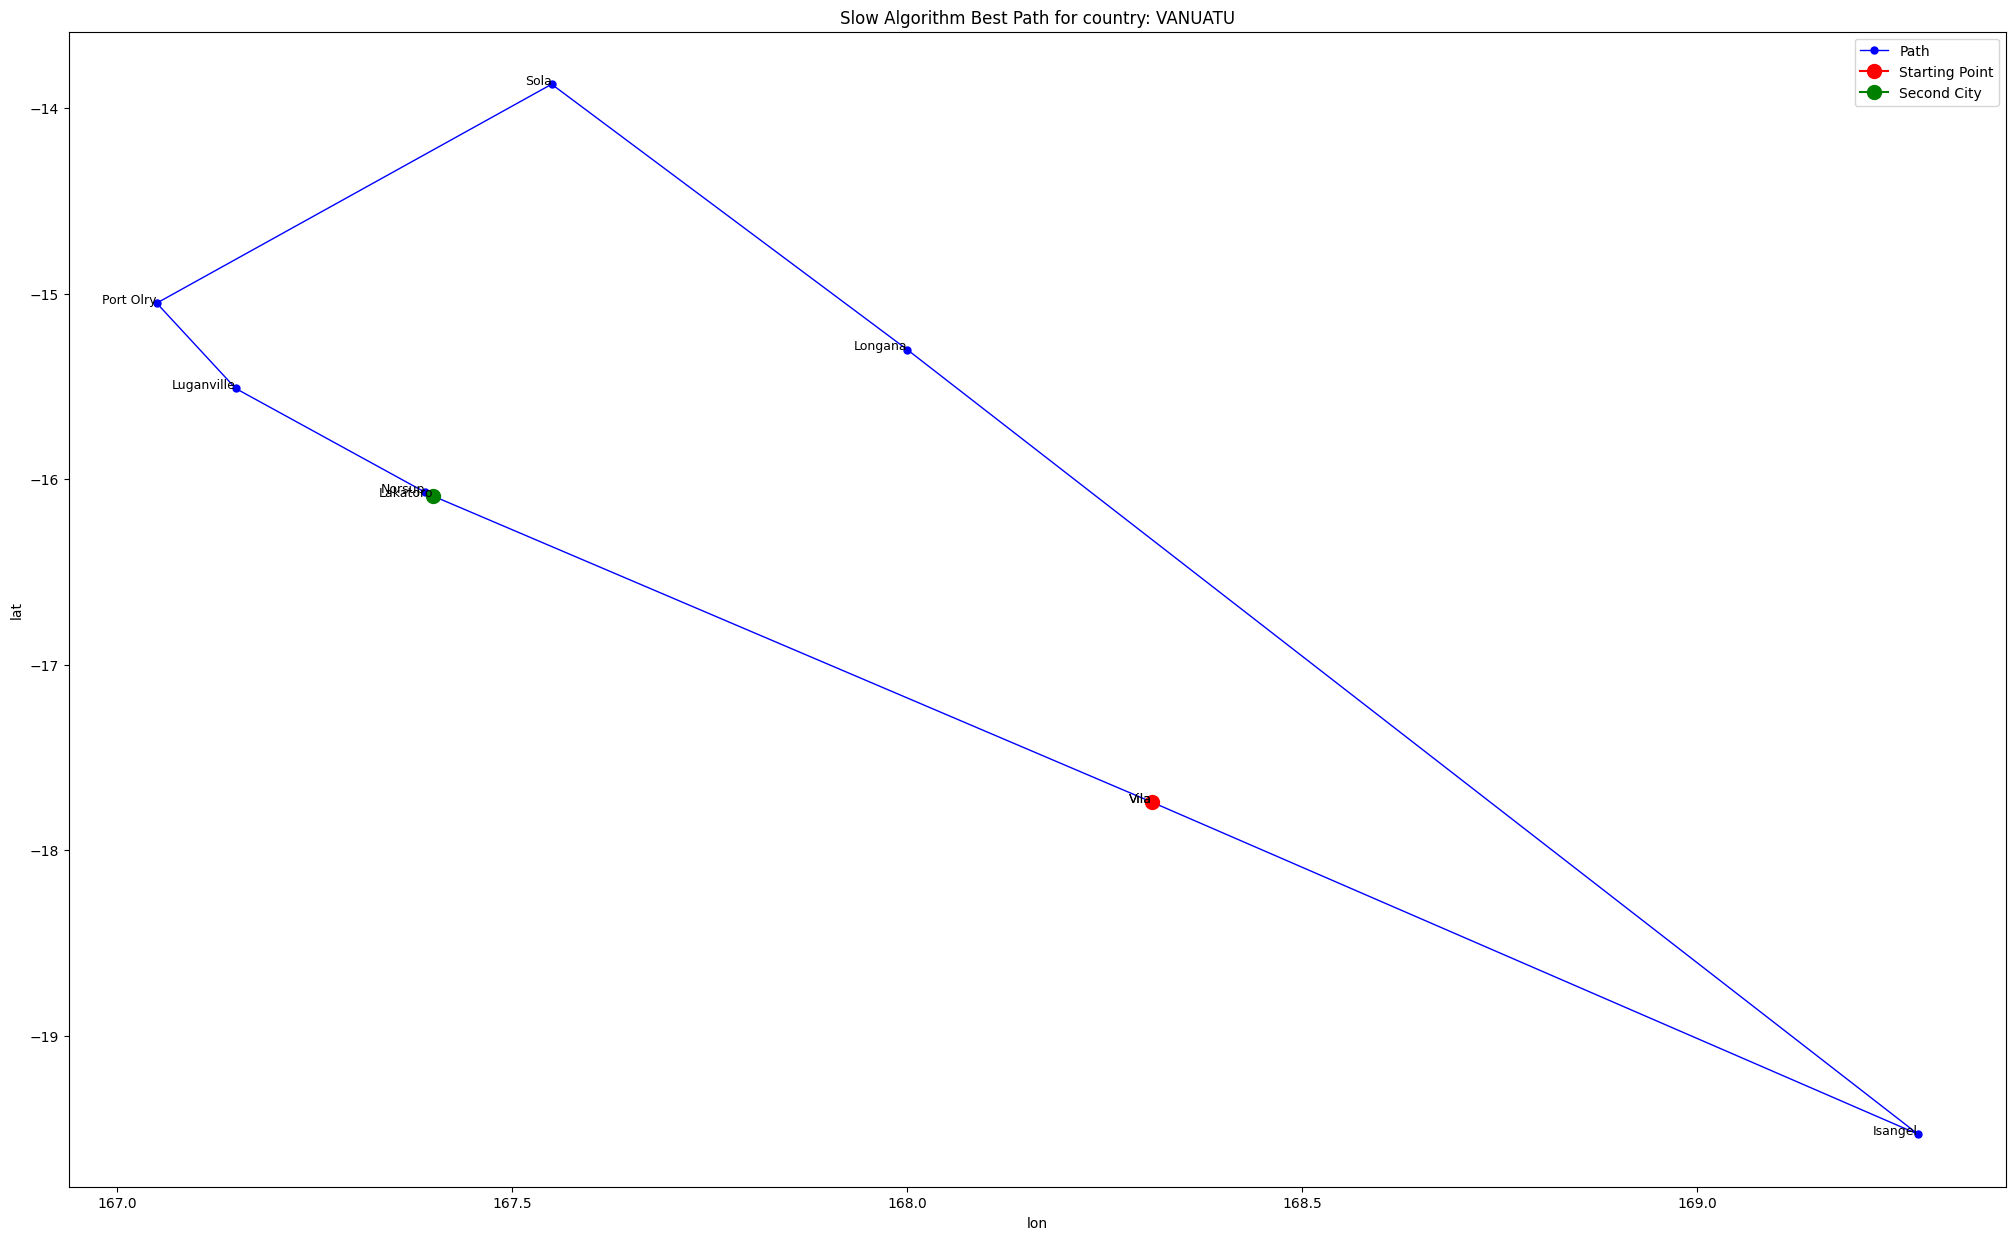

VANUATU Slow Algorithm execution time:  5.899755001068115




+-------------------------------------------------------+
|                                                       |
|                         ITALY                         |
|                                                       |
+-------------------------------------------------------+
-----------------------------
------ Quick Algorithm ------
-----------------------------
Country:  ITALY


  0%|          | 0/46 [00:00<?, ?it/s]

Number of cities: 46
Number of different costs: 44
Worst path cost: 5252.053875117022
Average cost: 4862.0964281101715
Best path cost: 4430.610170187765


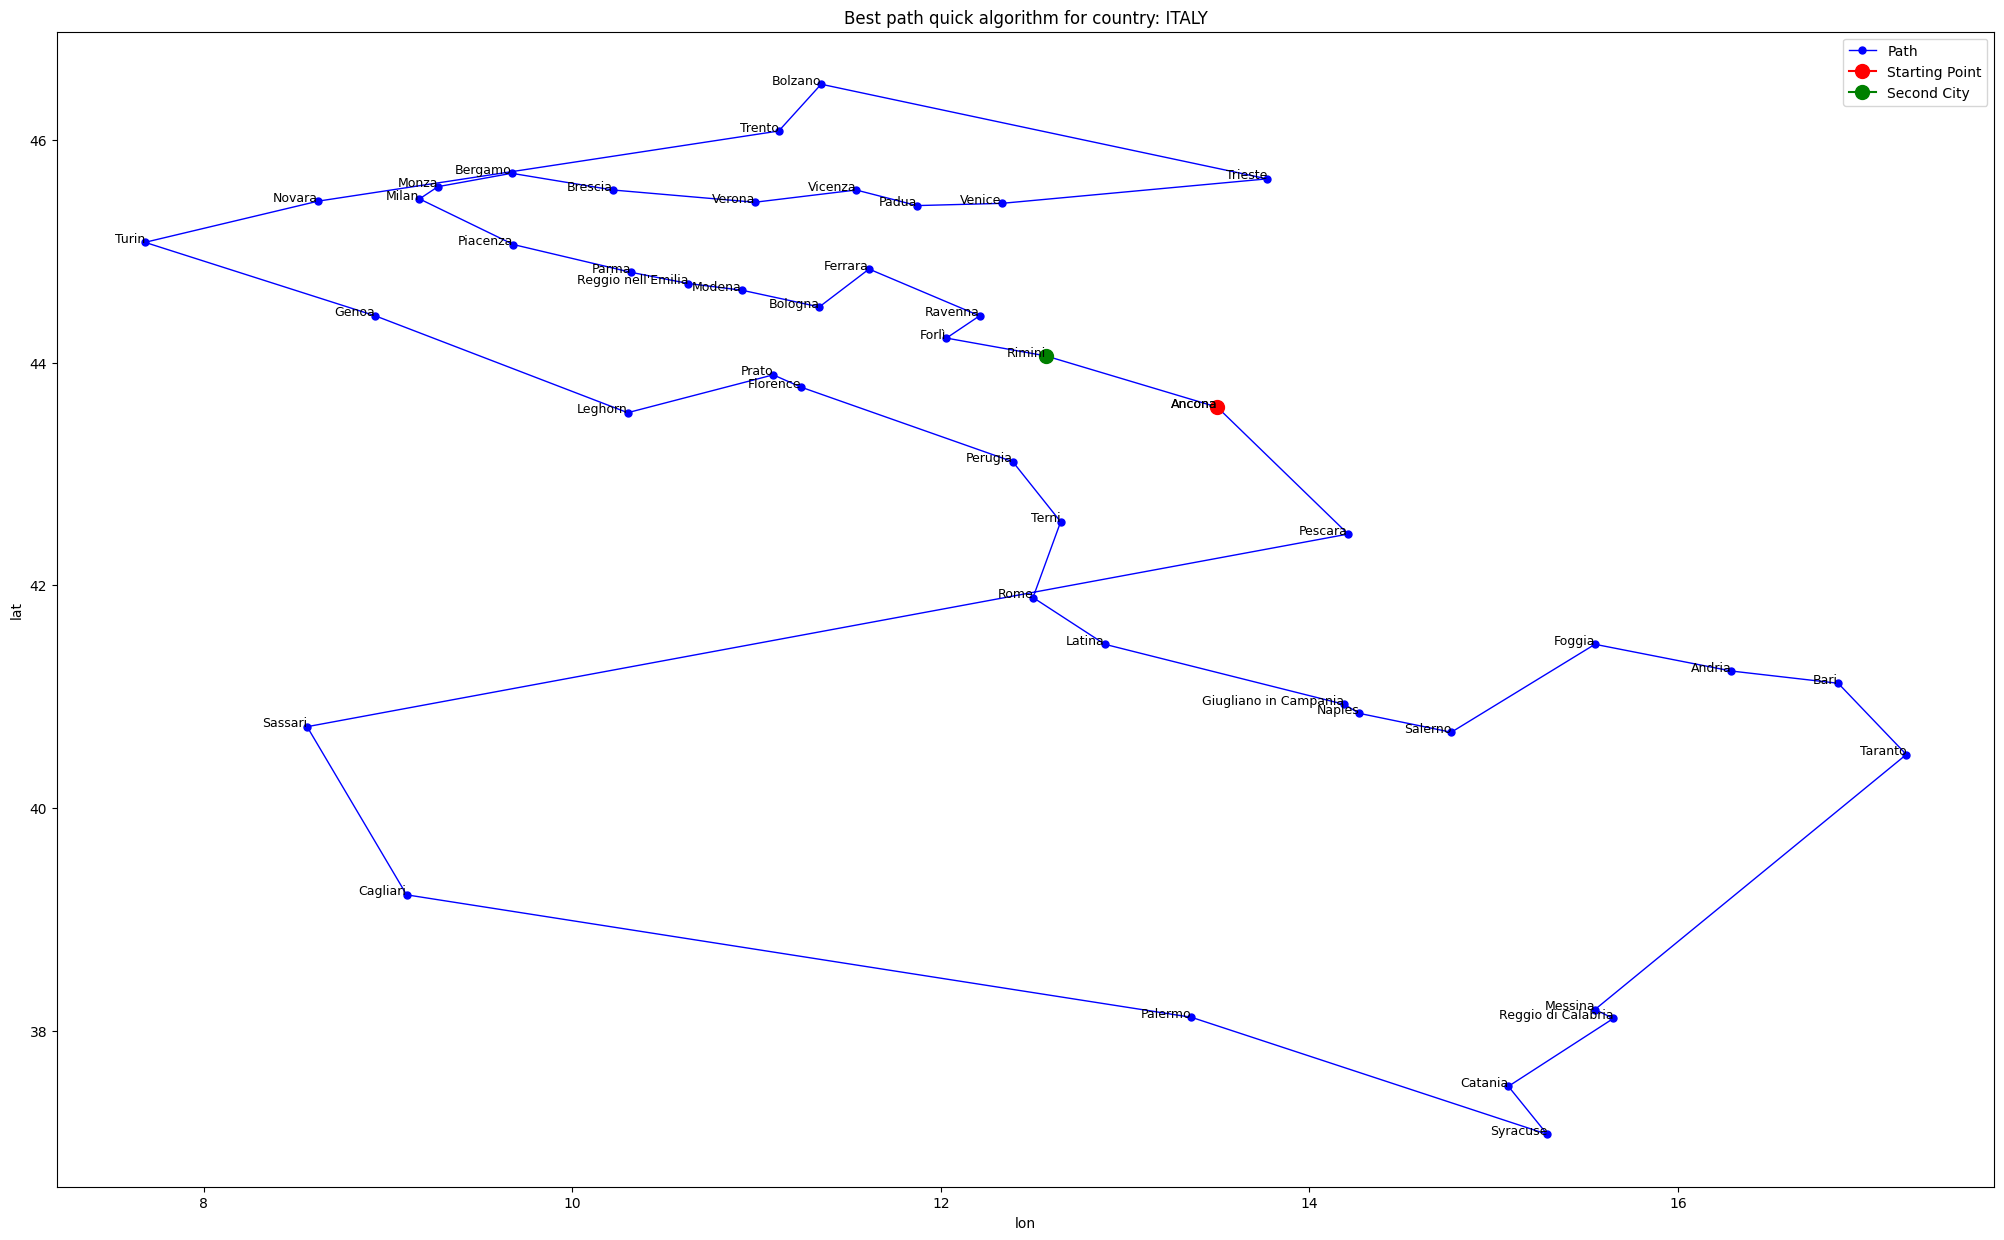

ITALY Quick Algorithm execution time:  0.3857557773590088


---------------------------
----- Slow Algorithm ------
---------------------------
Country: ITALY
Population Size: 50
Number of cities: 46
Number of Generations: 230
Elite Count: 7
Initializing the algorithm...
Best cost from quick algorithm: 4430.610170187765
Startign the algorithm...


  0%|          | 0/230 [00:00<?, ?it/s]

Generation 0, Best Cost so far: 4430.610170187765
Generation 23, Best Cost so far: 4430.610170187764, Improvement: 9.094947017729282e-13
Generation 46, Best Cost so far: 4366.248868666128, Improvement: 64.36130152163605
Generation 69, Best Cost so far: 4361.673947286311, Improvement: 4.5749213798171695
Generation 92, Best Cost so far: 4361.673947286311, Improvement: 0.0
Generation 115, Best Cost so far: 4361.673947286311, Improvement: 0.0
Generation 138, Best Cost so far: 4361.673947286311, Improvement: 0.0
Generation 161, Best Cost so far: 4361.673947286311, Improvement: 0.0
Generation 184, Best Cost so far: 4343.192333974028, Improvement: 18.481613312283116
Generation 207, Best Cost so far: 4343.192333974028, Improvement: 0.0
Best Cost: 4343.192333974028


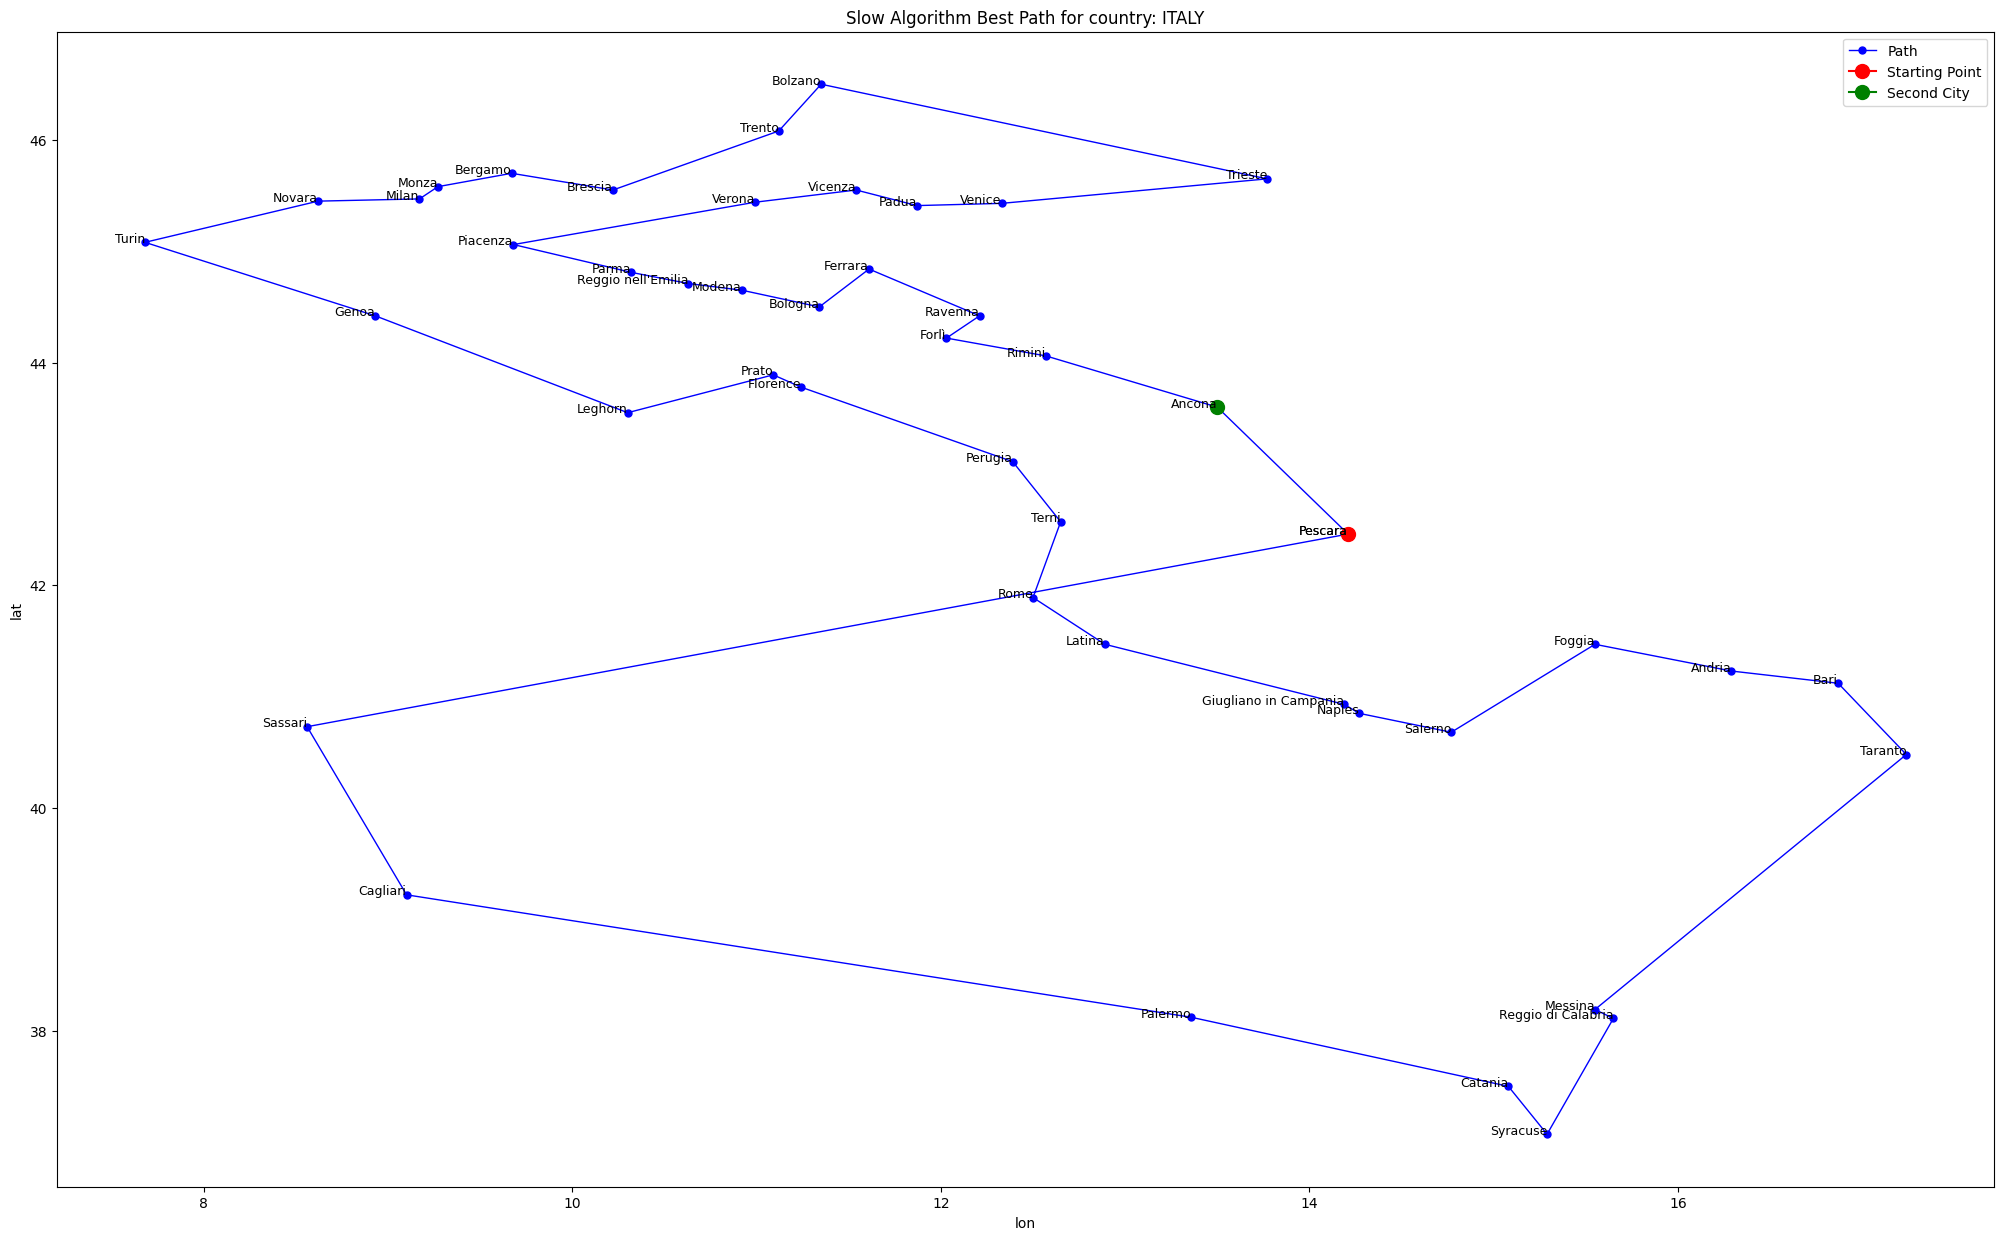

ITALY Slow Algorithm execution time:  12.770194053649902




+-------------------------------------------------------+
|                                                       |
|                        RUSSIA                         |
|                                                       |
+-------------------------------------------------------+
-----------------------------
------ Quick Algorithm ------
-----------------------------
Country:  RUSSIA


  0%|          | 0/167 [00:00<?, ?it/s]

Number of cities: 167
Number of different costs: 167
Worst path cost: 45968.49919165293
Average cost: 43197.94995910696
Best path cost: 39958.114204566016


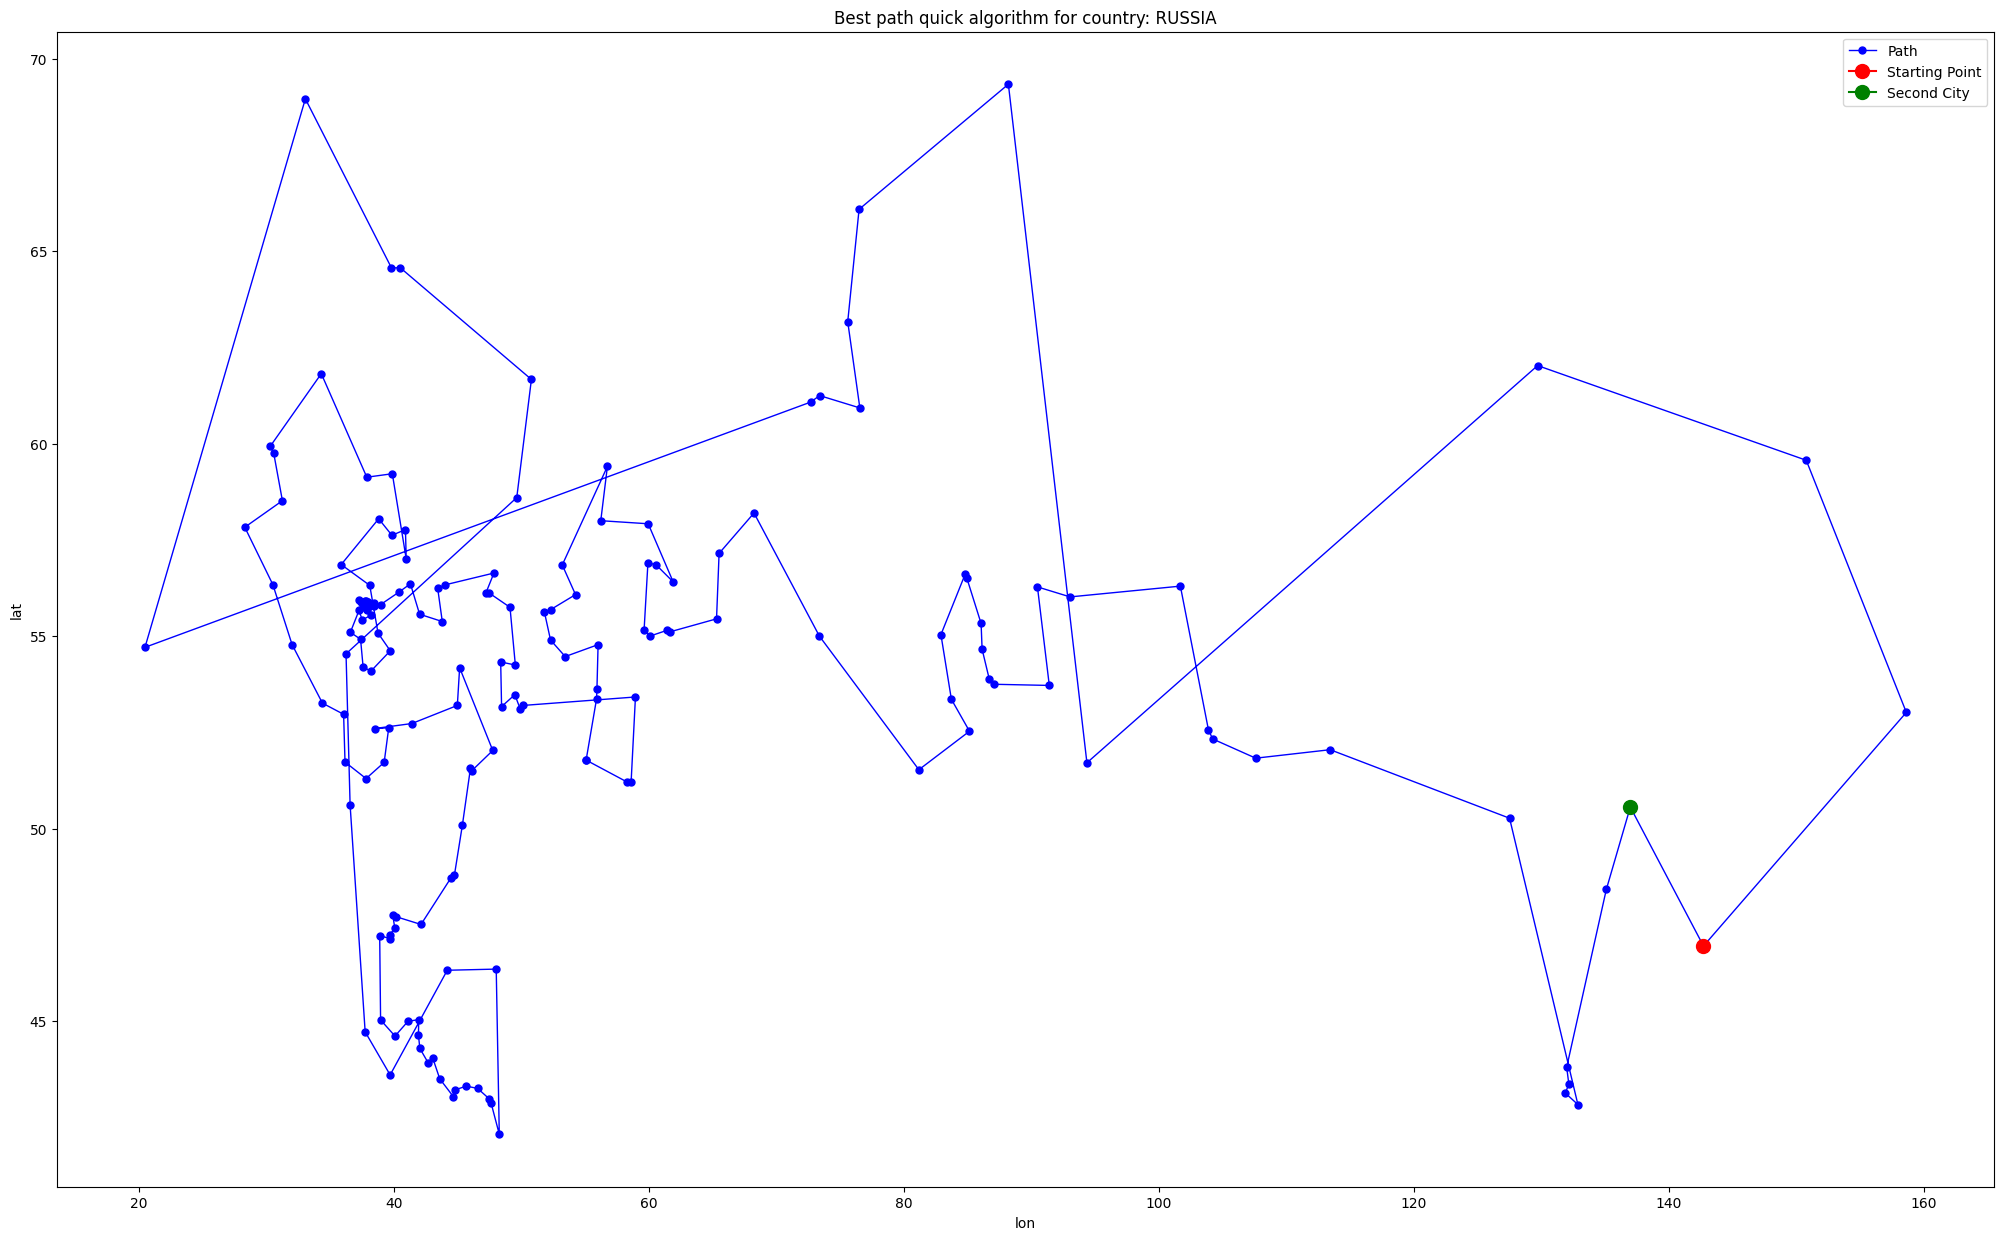

RUSSIA Quick Algorithm execution time:  1.223583698272705


---------------------------
----- Slow Algorithm ------
---------------------------
Country: RUSSIA
Population Size: 50
Number of cities: 167
Number of Generations: 835
Elite Count: 7
Initializing the algorithm...
Best cost from quick algorithm: 39958.114204566016
Startign the algorithm...


  0%|          | 0/835 [00:00<?, ?it/s]

Generation 0, Best Cost so far: 39958.114204566016
Generation 83, Best Cost so far: 38624.66535906712, Improvement: 1333.4488454988968
Generation 166, Best Cost so far: 38532.37858869811, Improvement: 92.28677036900626
Generation 249, Best Cost so far: 38183.19209049585, Improvement: 349.1864982022598
Generation 332, Best Cost so far: 38103.72200272468, Improvement: 79.47008777117298
Generation 415, Best Cost so far: 38103.72200272468, Improvement: 0.0
Generation 498, Best Cost so far: 38103.72200272468, Improvement: 0.0
Generation 581, Best Cost so far: 38103.72200272468, Improvement: 0.0
Generation 664, Best Cost so far: 38103.72200272468, Improvement: 0.0
Generation 747, Best Cost so far: 38103.72200272468, Improvement: 0.0
Generation 830, Best Cost so far: 38103.72200272468, Improvement: 0.0
Best Cost: 38101.371427066006


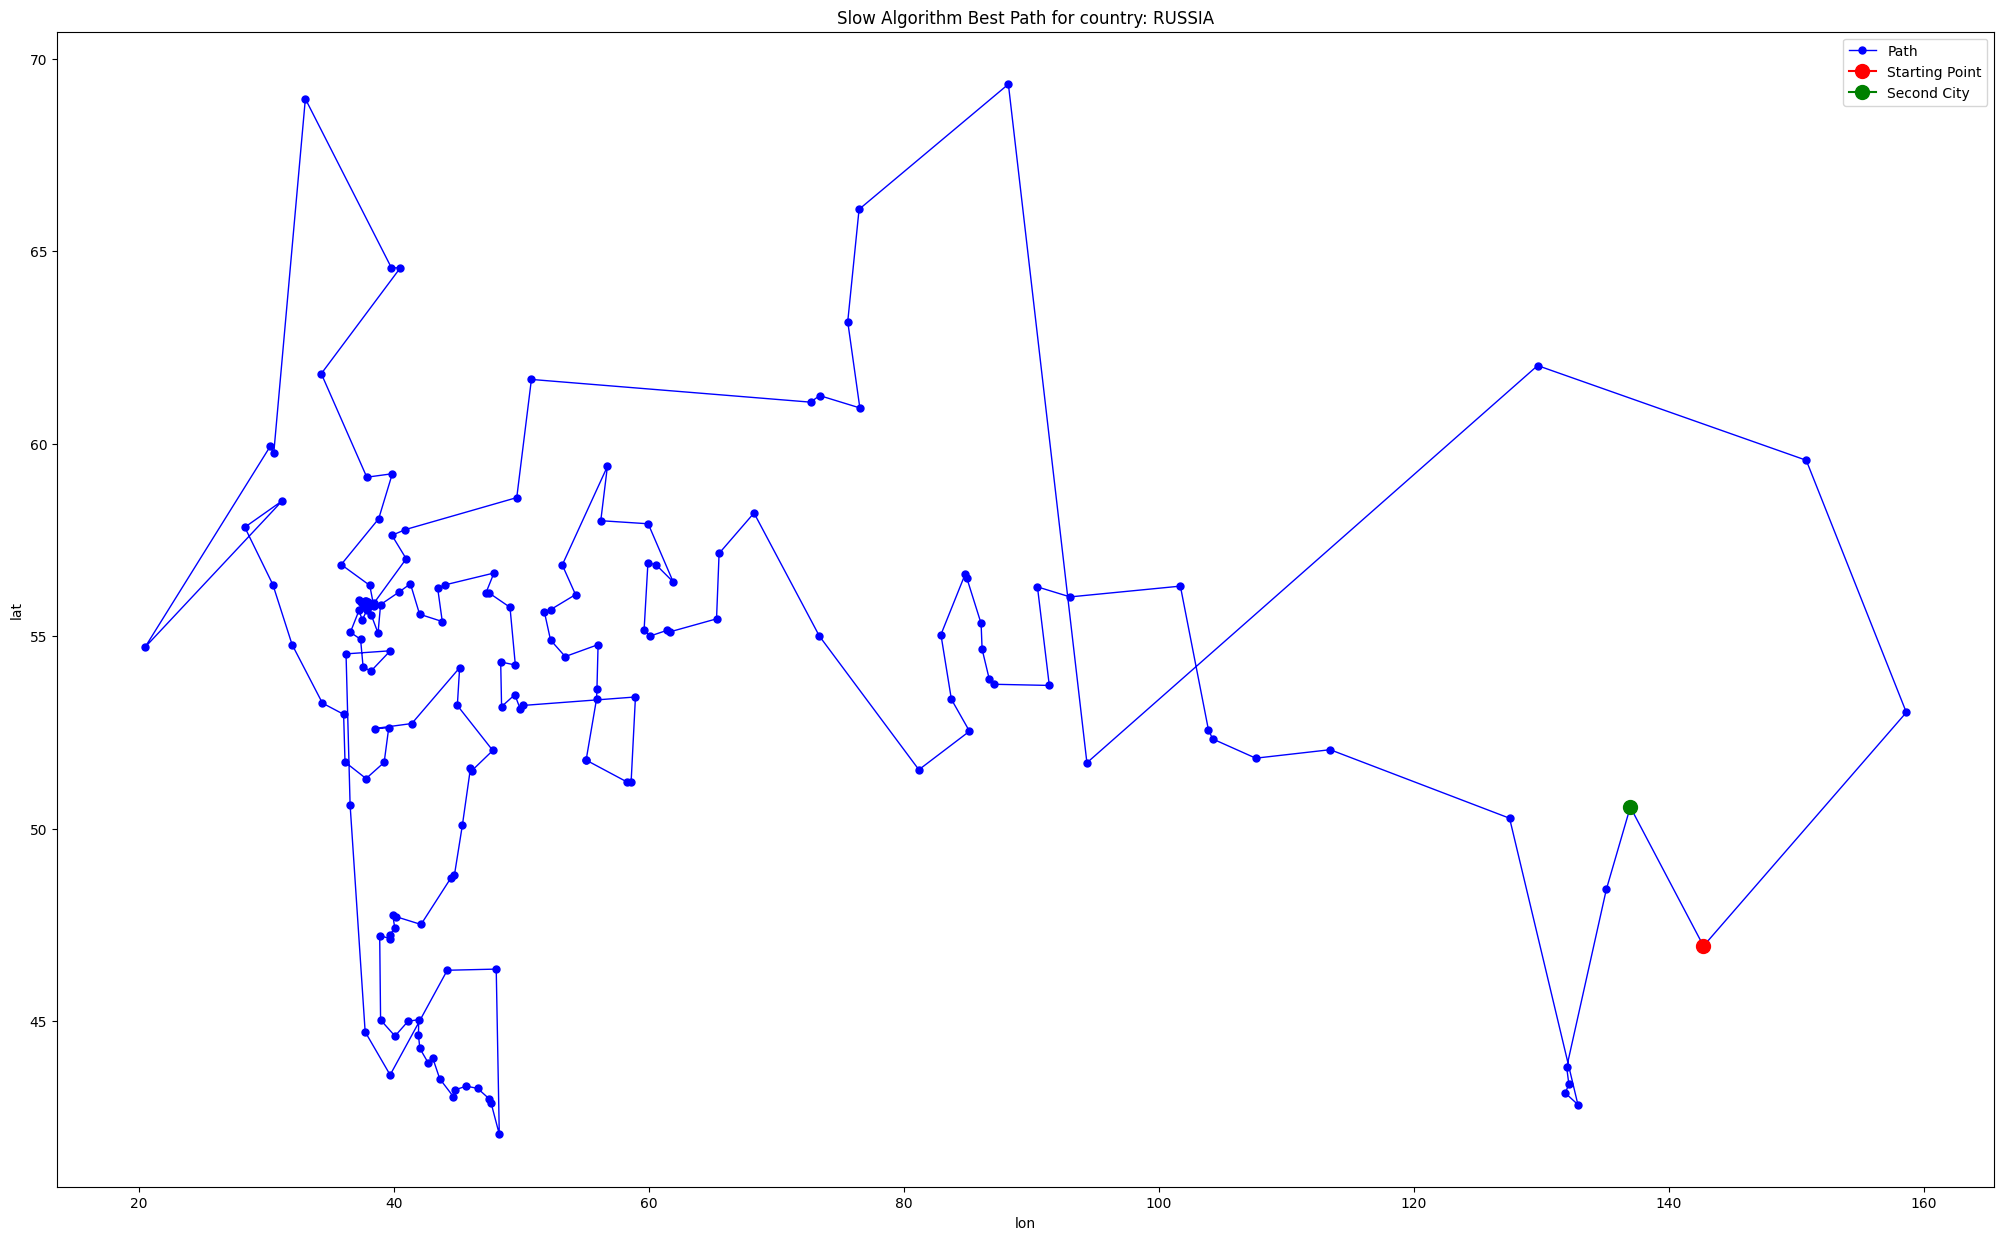

RUSSIA Slow Algorithm execution time:  139.81189846992493




+-------------------------------------------------------+
|                                                       |
|                          US                           |
|                                                       |
+-------------------------------------------------------+
-----------------------------
------ Quick Algorithm ------
-----------------------------
Country:  US


  0%|          | 0/326 [00:00<?, ?it/s]

Number of cities: 326
Number of different costs: 326
Worst path cost: 53188.39545619914
Average cost: 49032.762203163744
Best path cost: 46246.806864142134


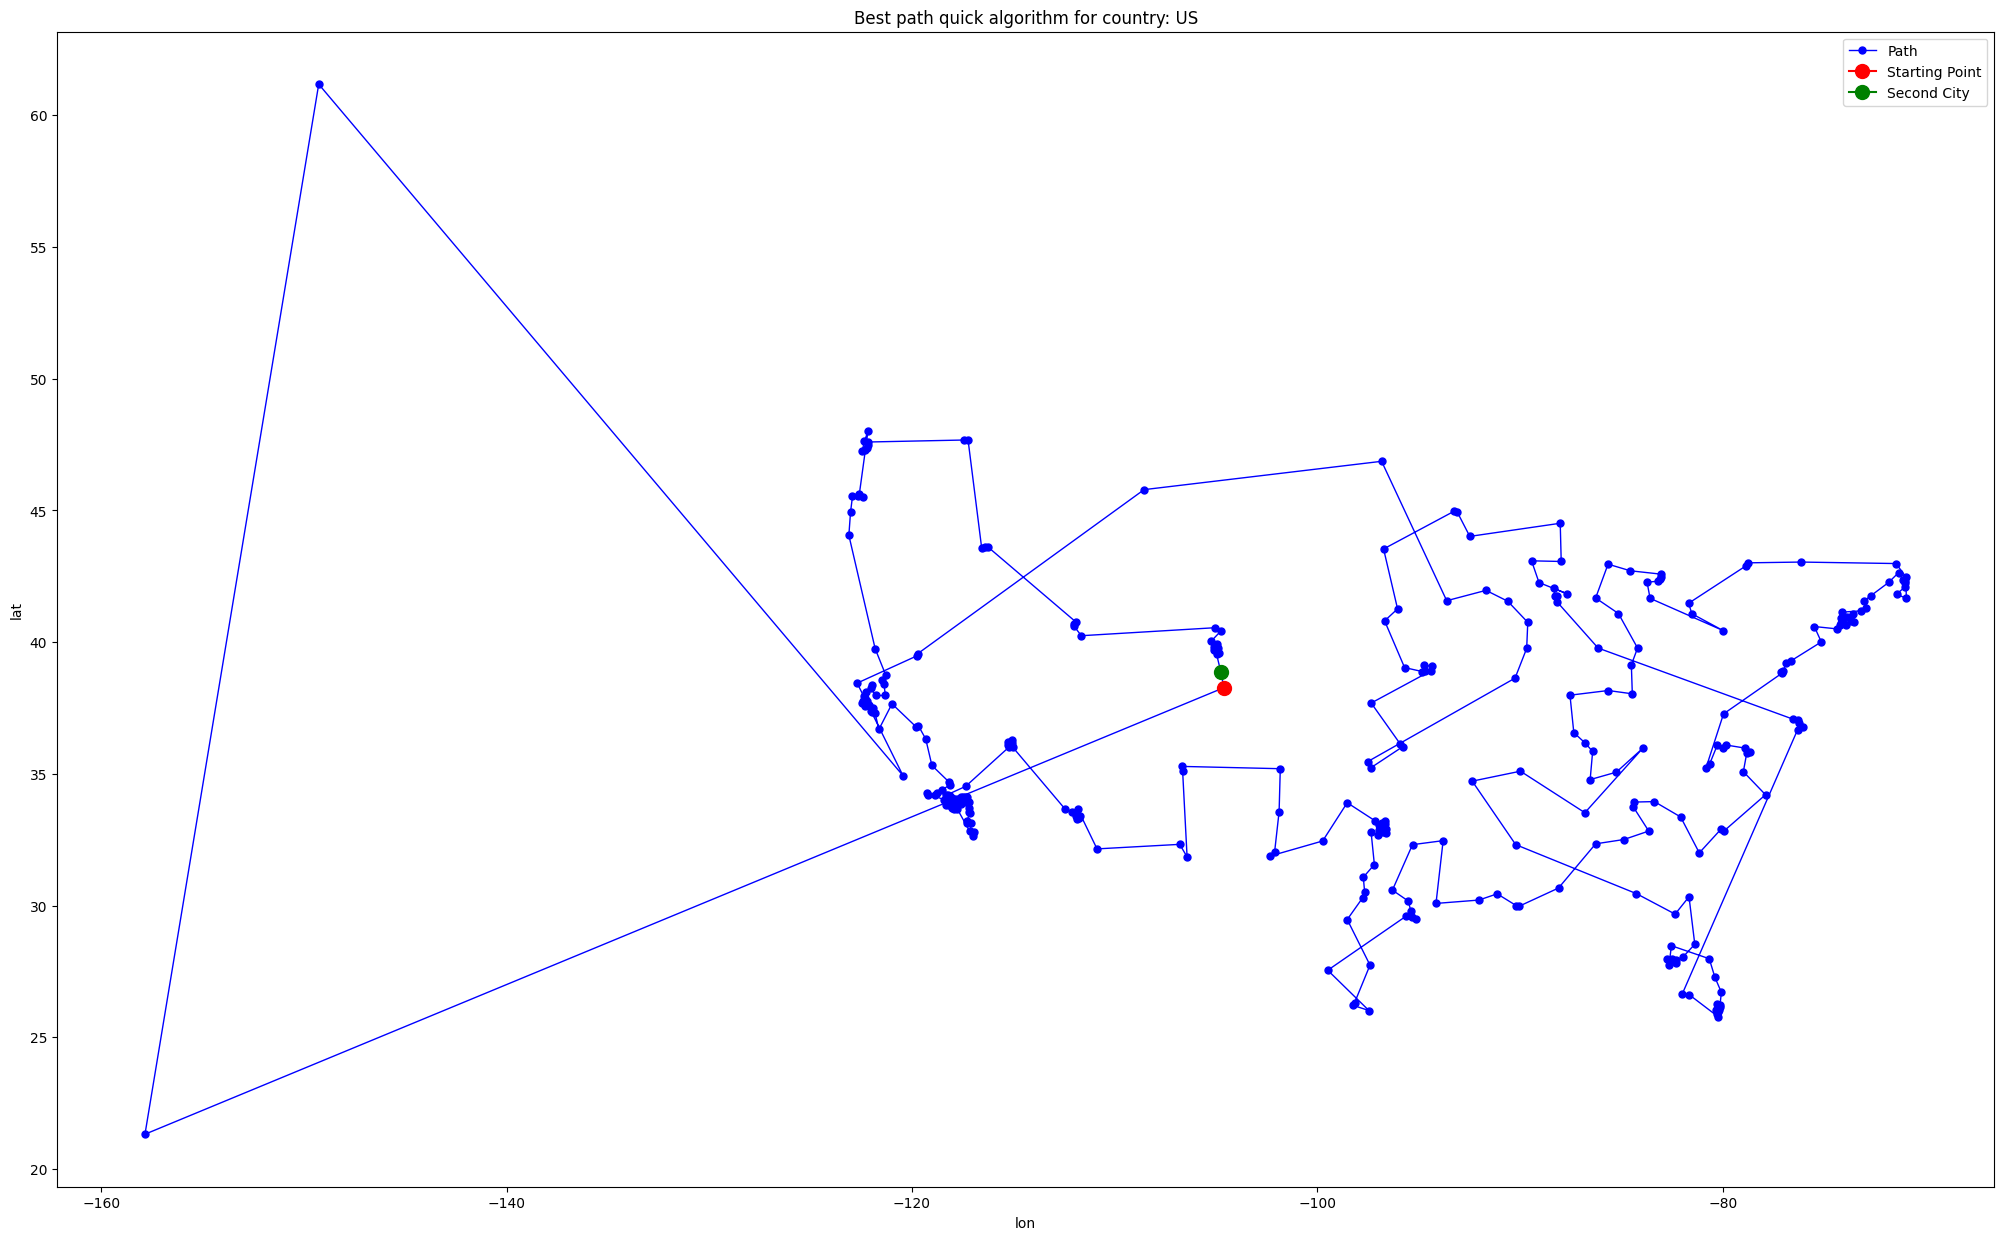

US Quick Algorithm execution time:  6.6216652393341064


---------------------------
----- Slow Algorithm ------
---------------------------
Country: US
Population Size: 50
Number of cities: 326
Number of Generations: 1630
Elite Count: 7
Initializing the algorithm...
Best cost from quick algorithm: 46246.806864142134
Startign the algorithm...


  0%|          | 0/1630 [00:00<?, ?it/s]

Generation 0, Best Cost so far: 46246.806864142134
Generation 163, Best Cost so far: 46030.112728473185, Improvement: 216.69413566894946
Generation 326, Best Cost so far: 46030.112728473185, Improvement: 0.0
Generation 489, Best Cost so far: 45818.06899706807, Improvement: 212.04373140511598
Generation 652, Best Cost so far: 45803.891673836464, Improvement: 14.177323231604532
Generation 815, Best Cost so far: 45796.44123499046, Improvement: 7.450438846004545
Generation 978, Best Cost so far: 45796.44123499046, Improvement: 0.0
Generation 1141, Best Cost so far: 45779.11809606272, Improvement: 17.323138927742548
Generation 1304, Best Cost so far: 45772.22173242589, Improvement: 6.896363636828028
Generation 1467, Best Cost so far: 45772.22173242589, Improvement: 0.0
Best Cost: 45765.94329022744


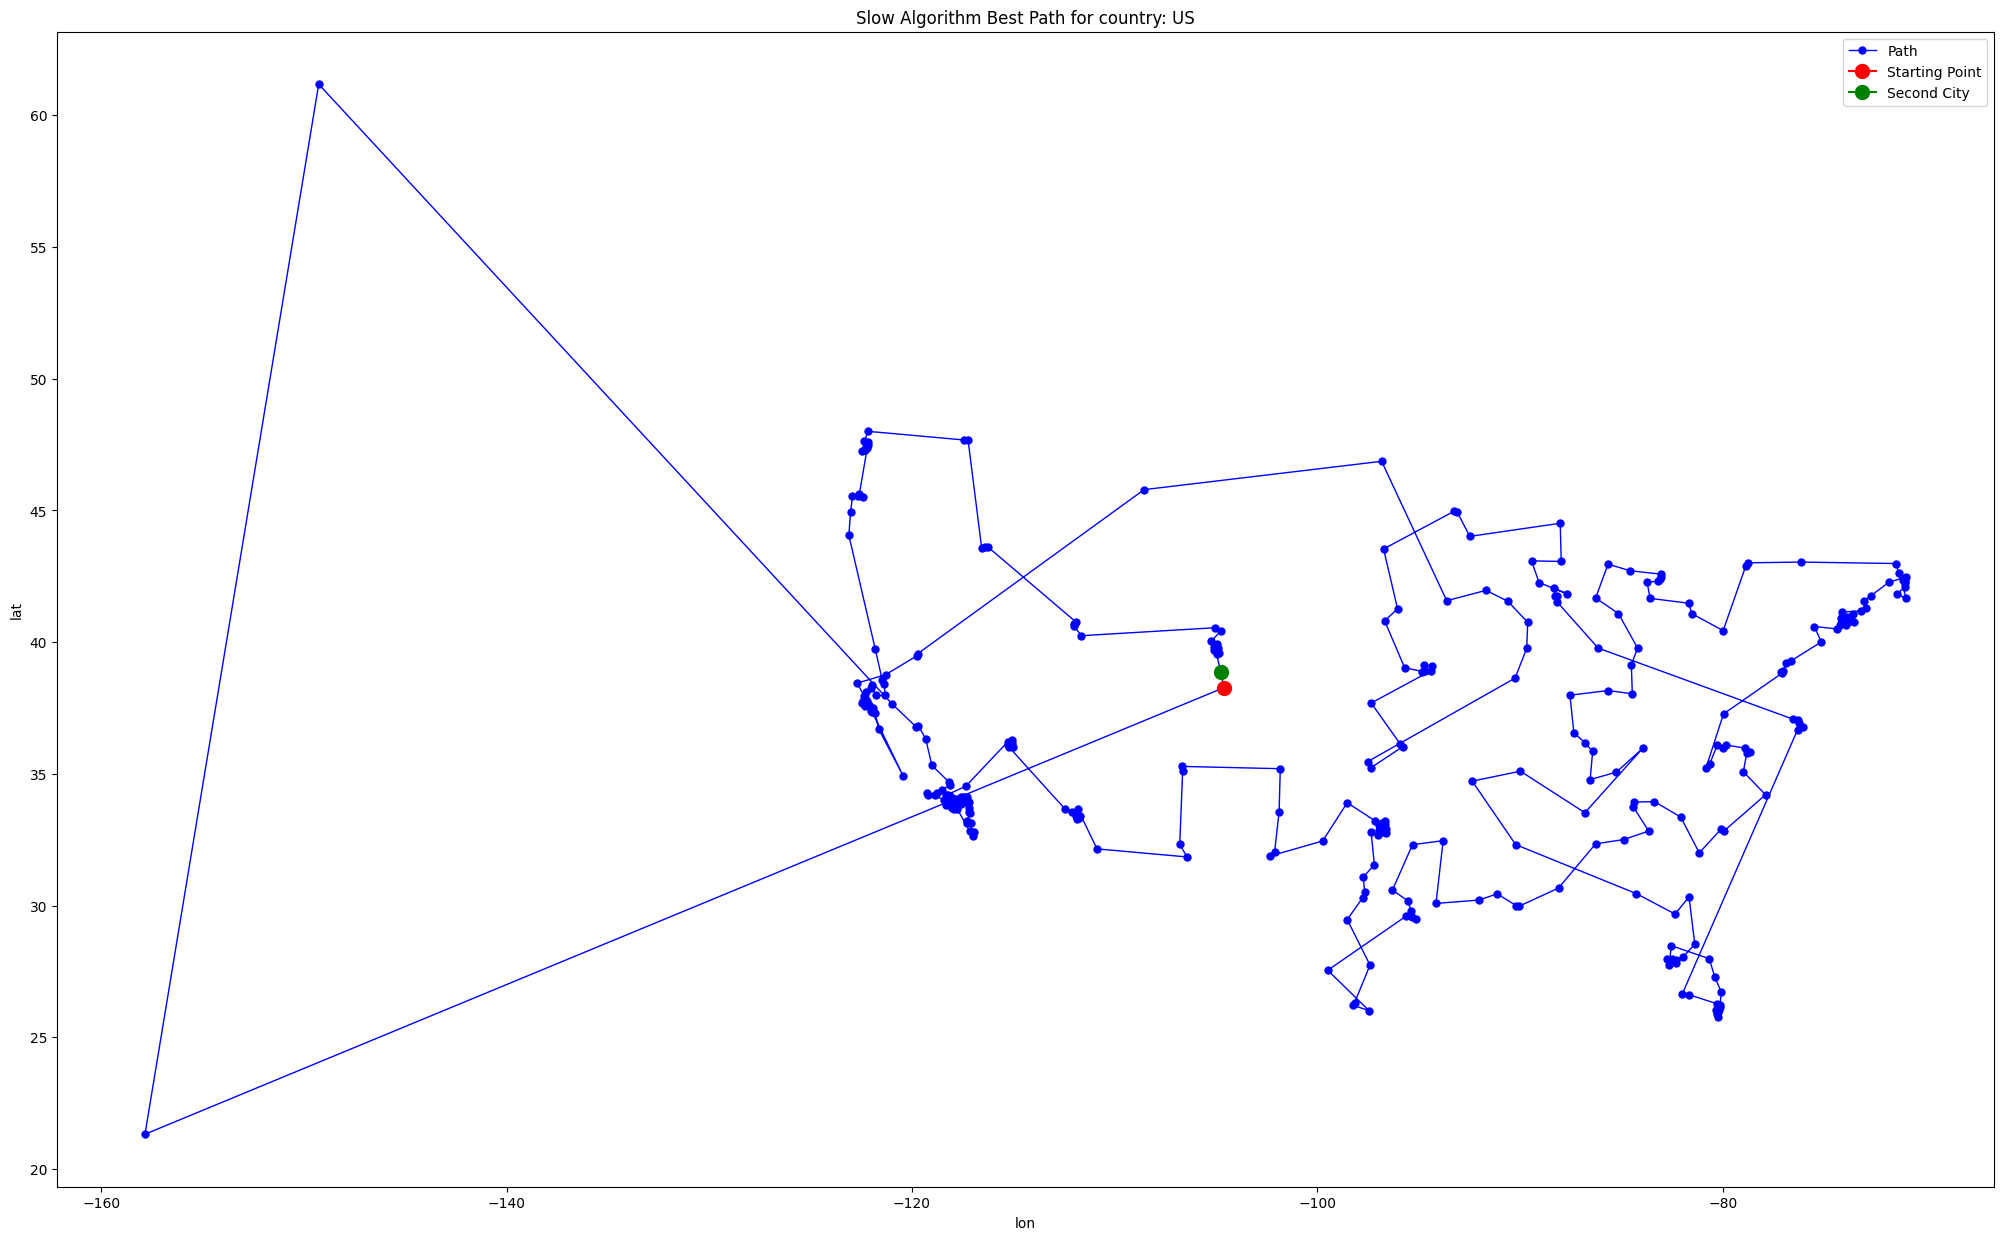

US Slow Algorithm execution time:  592.9098479747772




+-------------------------------------------------------+
|                                                       |
|                         CHINA                         |
|                                                       |
+-------------------------------------------------------+
-----------------------------
------ Quick Algorithm ------
-----------------------------
Country:  CHINA


  0%|          | 0/726 [00:00<?, ?it/s]

Number of cities: 726
Number of different costs: 723
Worst path cost: 66649.1544300641
Average cost: 64188.76187340383
Best path cost: 61622.53379466217


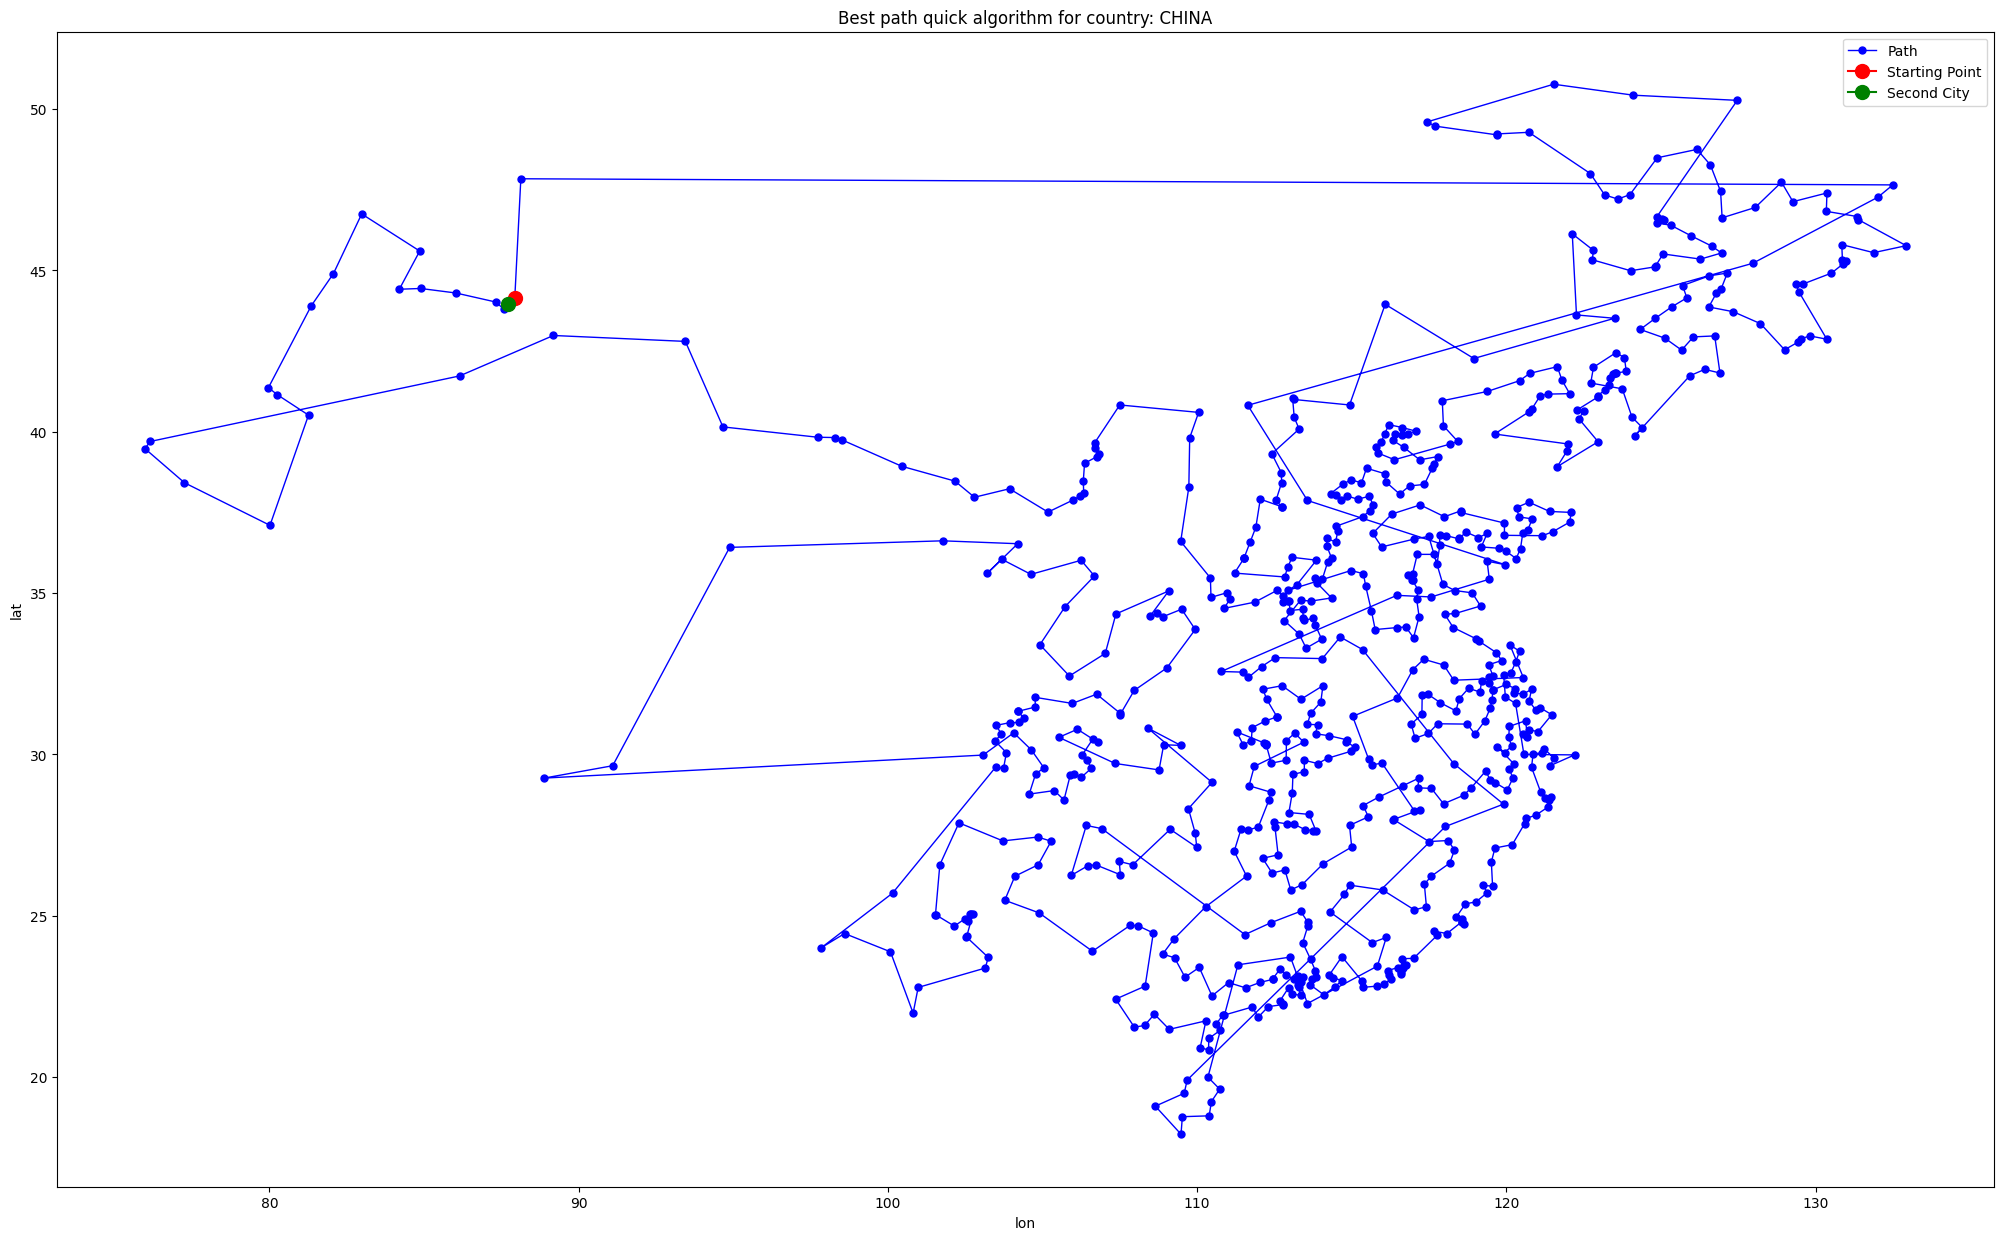

CHINA Quick Algorithm execution time:  61.9439582824707


---------------------------
----- Slow Algorithm ------
---------------------------
Country: CHINA
Population Size: 50
Number of cities: 726
Number of Generations: 2000
Elite Count: 7
Initializing the algorithm...
Best cost from quick algorithm: 61622.53379466217
Startign the algorithm...


  0%|          | 0/2000 [00:00<?, ?it/s]

Generation 0, Best Cost so far: 61622.53379466217
Generation 200, Best Cost so far: 61590.609478838094, Improvement: 31.924315824078803
Generation 400, Best Cost so far: 61590.609478838094, Improvement: 0.0
Generation 600, Best Cost so far: 61537.90505928991, Improvement: 52.704419548186706
Generation 800, Best Cost so far: 61520.671882004965, Improvement: 17.23317728494294
Generation 1000, Best Cost so far: 61418.62343104721, Improvement: 102.04845095775818
Generation 1200, Best Cost so far: 61418.62343104721, Improvement: 0.0
Generation 1400, Best Cost so far: 61410.21301918173, Improvement: 8.410411865479546
Generation 1600, Best Cost so far: 61410.21301918173, Improvement: 0.0
Generation 1800, Best Cost so far: 61410.21301918173, Improvement: 0.0
Best Cost: 61386.01102533446


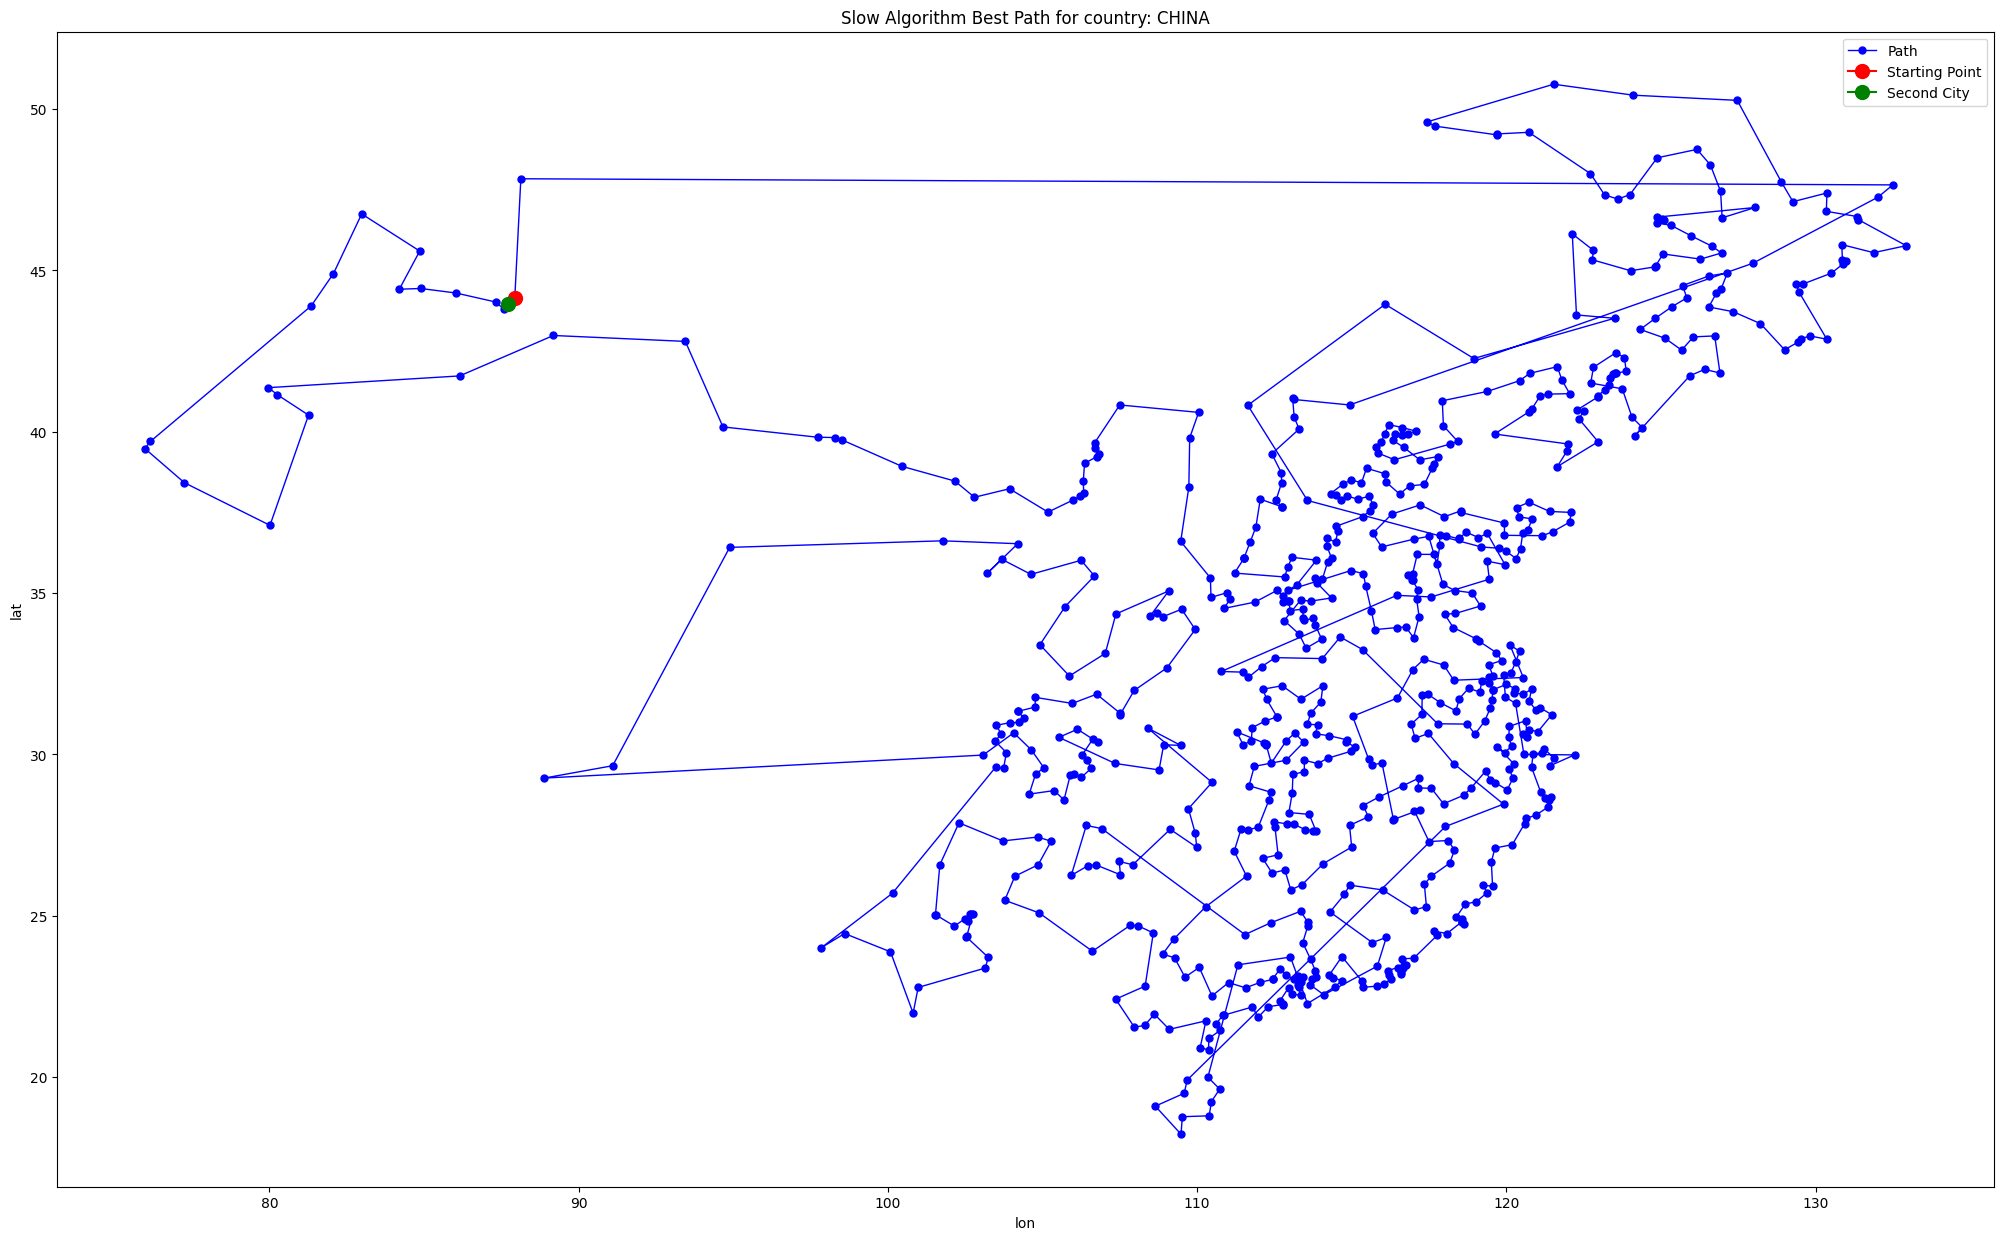

CHINA Slow Algorithm execution time:  2648.5884165763855




Total execution time:  2710.53253030777
+-------------------------------------------------------+
|                                                       |
|                      ITALY_SMALL                      |
|                                                       |
+-------------------------------------------------------+
-----------------------------
------ Quick Algorithm ------
-----------------------------
Country:  ITALY_SMALL


  0%|          | 0/7 [00:00<?, ?it/s]

Number of cities: 7
Number of different costs: 5
Worst path cost: 1752.9861699813532
Average cost: 1702.744843930177
Best path cost: 1691.8971593437484


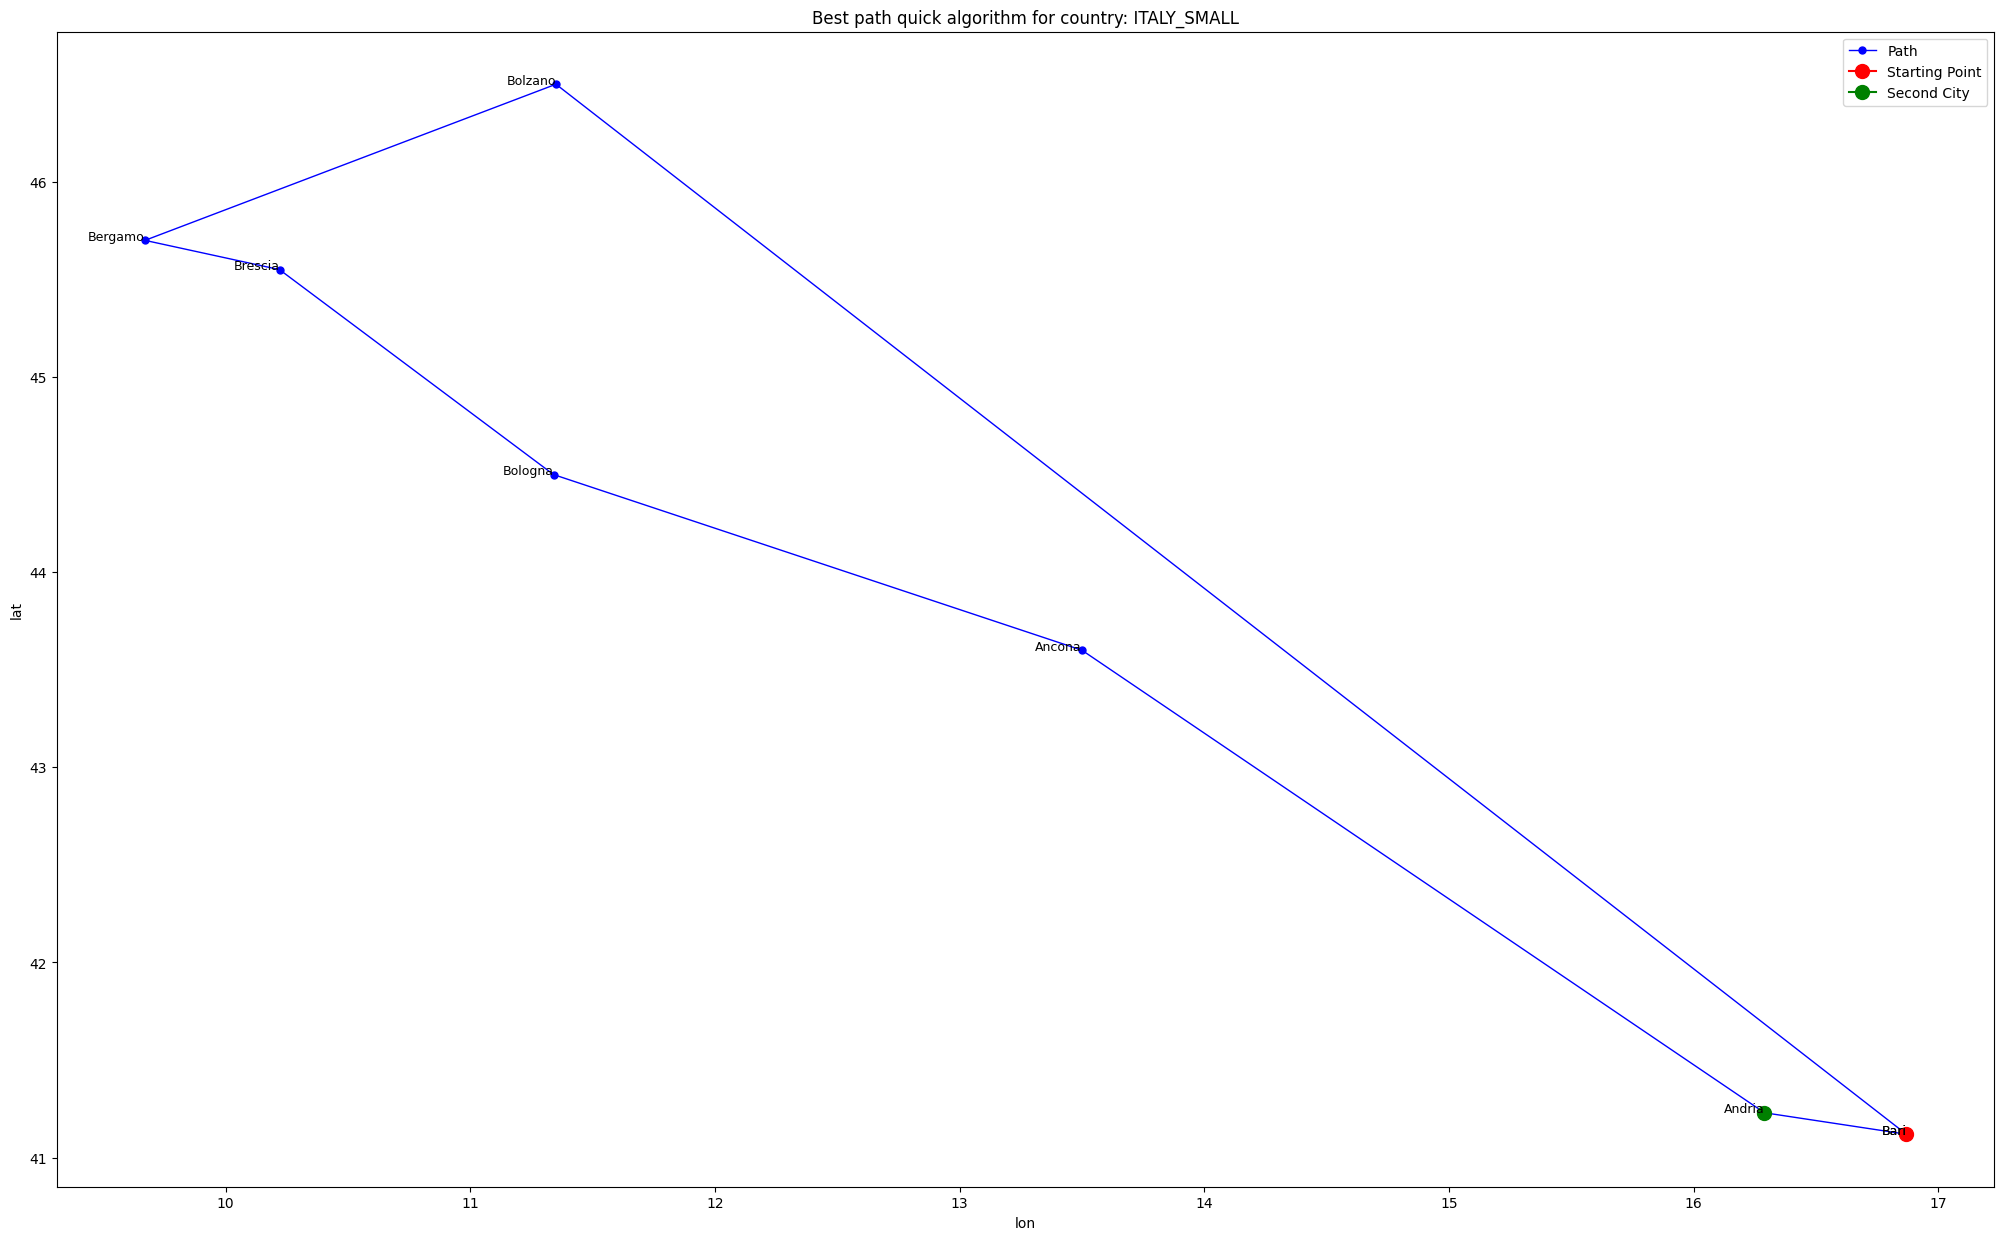

ITALY_SMALL Quick Algorithm execution time:  0.24391937255859375


---------------------------
----- Slow Algorithm ------
---------------------------
Country: ITALY_SMALL
Population Size: 50
Number of cities: 7
Number of Generations: 100
Elite Count: 7
Initializing the algorithm...
Best cost from quick algorithm: 1691.8971593437484
Startign the algorithm...


  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0, Best Cost so far: 1691.8971593437484
Generation 10, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Generation 20, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Generation 30, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Generation 40, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Generation 50, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Generation 60, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Generation 70, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Generation 80, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Generation 90, Best Cost so far: 1691.8971593437484, Improvement: 0.0
Best Cost: 1691.8971593437484


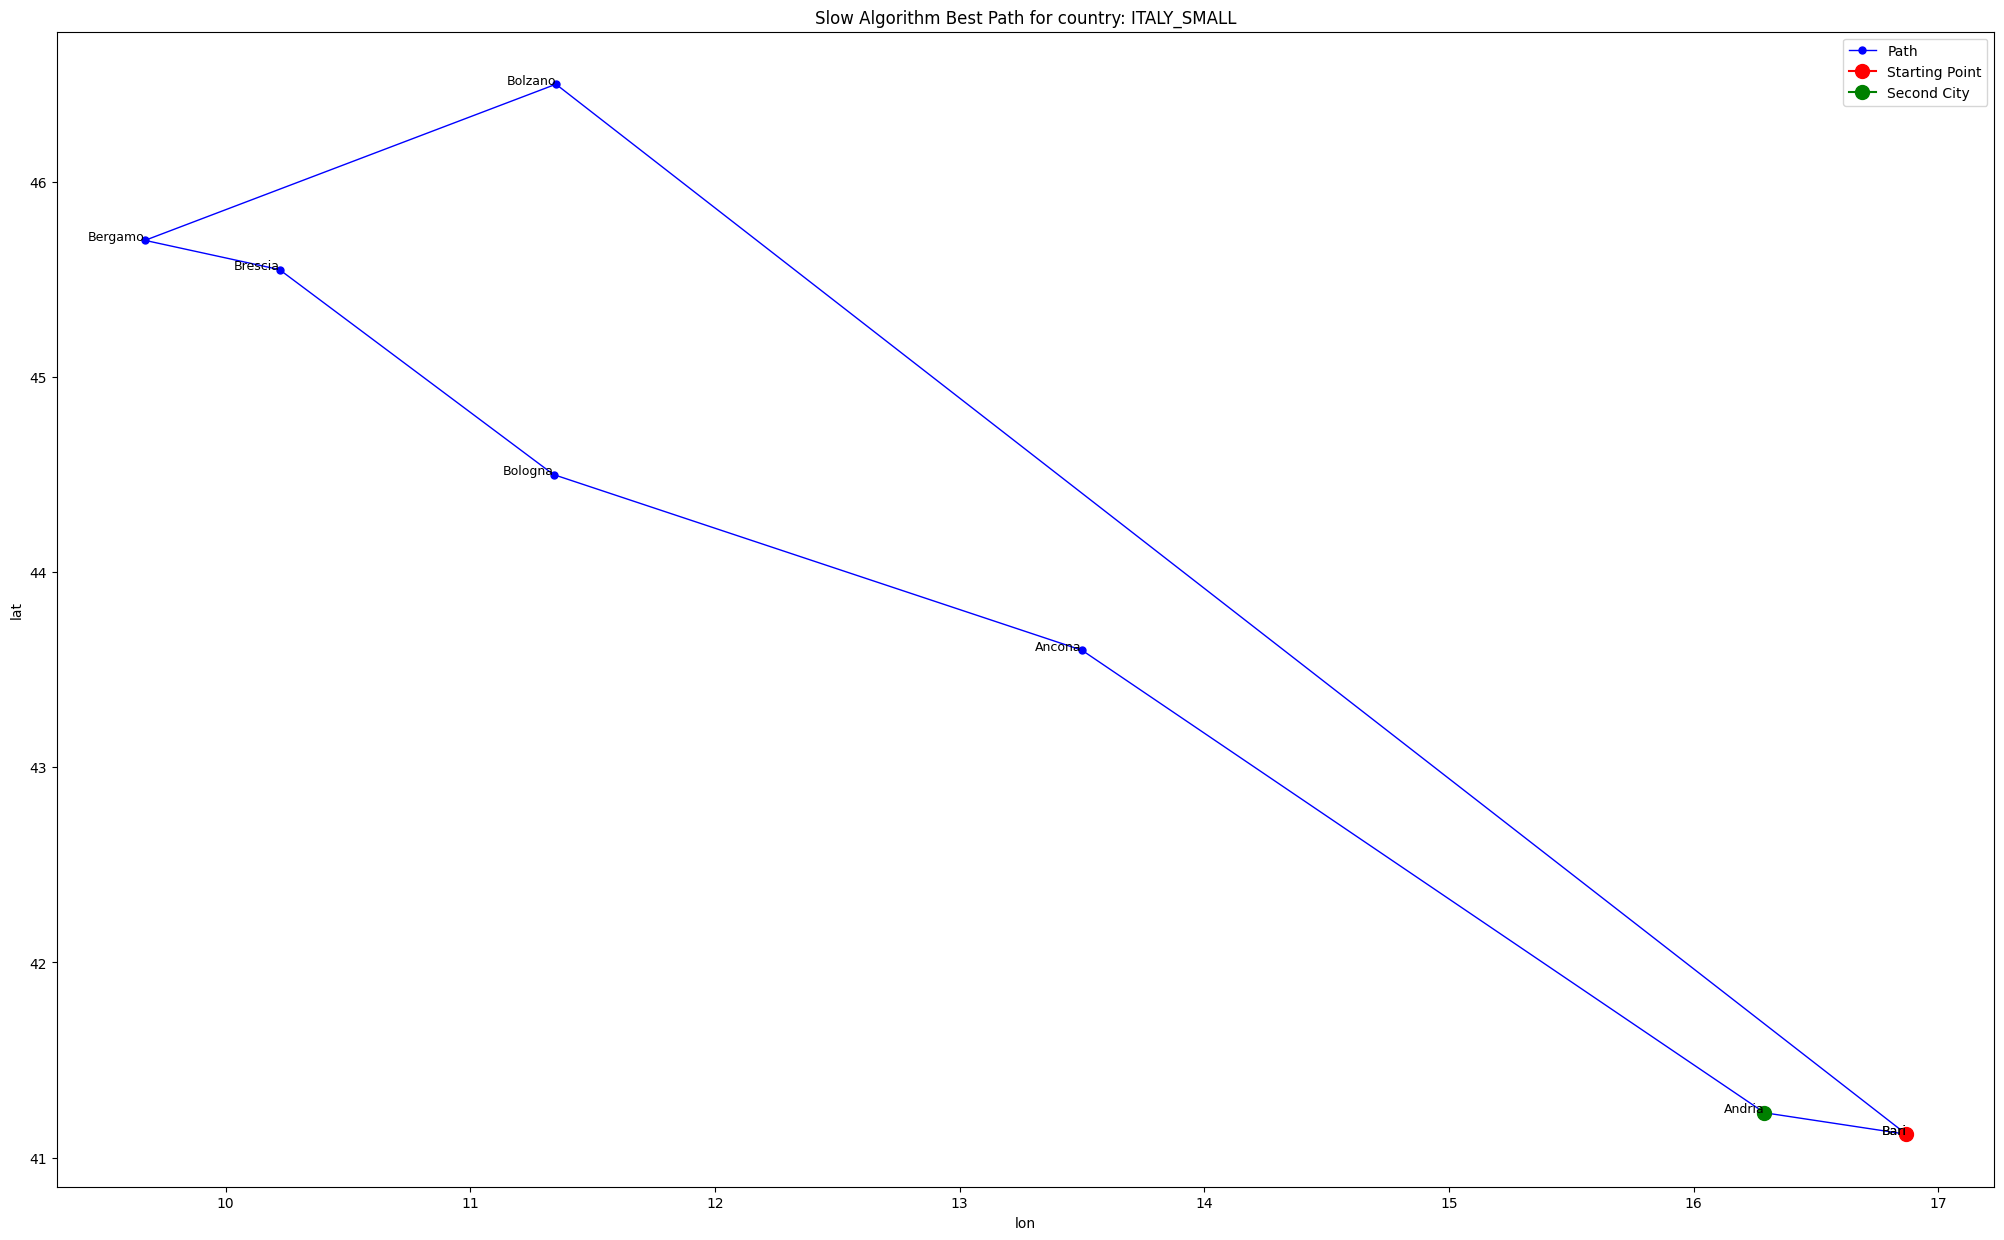

ITALY_SMALL Slow Algorithm execution time:  7.381047964096069






In [ ]:
# MAIN


# 1 = Vanuatu
# 2 = Italy
# 3 = Russia
# 4 = US
# 5 = China

# the files must be in the ./cities folder

for i in [1, 2, 3, 4, 5, 0]:
	file = i

	if file == 1:
		PATH_FILE = './cities/vanuatu.csv'
	elif file == 2:
		PATH_FILE = './cities/italy.csv'
	elif file == 3:
		PATH_FILE = './cities/russia.csv'
	elif file == 4:
		PATH_FILE = './cities/us.csv'
	elif file == 5:
		PATH_FILE = './cities/china.csv'
	elif file == 0:
		PATH_FILE = './cities/italy_small.csv'
	else:
		print("Invalid file")
		exit()

	# SETUP
	read_data()
	fill_distance_matrix()
	#print_data()

	str = PATH_FILE.split('/')[2].split('.')[0]
	str = str.upper()

	print("+" + "-"*55 + "+")
	print("|" + " " * 55 + "|")
	print("|" + f"{str:^55}" + "|")
	print("|" + " " * 55 + "|")
	print("+" + "-"*55 + "+")

	# ALGORITHM
	start_start_time = time.time()
	start_time = time.time()

	best_paths_quick = quick_algorithm(str)

	execution_time_quick = time.time() - start_time

	print(str, "Quick Algorithm execution time: ", execution_time_quick)
	print("\n")

	start_time = time.time()

	slow_algorithm(str, best_paths_quick)

	execution_time_slow = time.time() - start_time

	print(str, "Slow Algorithm execution time: ", execution_time_slow)
	print("\n\n\n")

	# if last file, print total execution time
	if file == 5:
		print("Total execution time: ", time.time() - start_start_time)

